## This notebook is for statistical analysis & plotting

In [1]:
#last update: 21-02-23 #used sort2

## 1. Import module, parameter file, and preprocessed file

In [2]:
SORT_VER = 'sort2'

In [3]:
#cd /Users/dlee/moving-bar

In [4]:
import sys
sys.path.append('../')
if sys.platform == 'darwin':
    MAC0_OR_LINUX1 = 0
else:
    MAC0_OR_LINUX1 = 1

In [5]:
import numpy as np
import scipy.stats
import scipy.ndimage
import sklearn.linear_model
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import sklearn.decomposition
import sklearn.cluster
import tqdm
import pickle
import copy

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nlt
import experiment as exp
import extract as ext
import utils
import stats
import analysis
from analysis import ts2st

%load_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
def smooth(mat, s1=1, s2=1):
    return scipy.ndimage.gaussian_filter(mat, [s1, s2])
def smooth_1d(mat, s=1):
    return scipy.ndimage.gaussian_filter1d(mat, s)
def nn(mat, pad=0):
    temp_mat = copy.deepcopy(mat)
    temp_mat[np.isnan(temp_mat)] = pad
    return temp_mat

In [7]:
def tr(mat, pad='nan'):
    if pad == 'zero':
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant')[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    else:
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant', constant_values=(np.nan, np.nan))[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    return copy.deepcopy(mat_tr)

In [8]:
utils.set_plot_params()

In [9]:
if MAC0_OR_LINUX1 == 1:
    home_dir = '/home'
elif MAC0_OR_LINUX1 == 0:
    home_dir = '/Users'
proj_dir = home_dir + '/dlee/moving-bar/'
exp_list = ['17-10-18', '17-10-20', '17-10-26', '17-10-26-1', '17-10-27',
            '17-11-06', '17-11-07', '17-11-08', '17-11-14', '17-11-14-1',
            '17-11-29', '18-03-12', '18-03-22', '18-03-23', '18-03-24',
            '18-03-24-1', '18-03-27', '18-04-23']
N_expt = len(exp_list)
stim_sort_total_list = ['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                        'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m']
stim_notforsort_total_list = ['line', 'rf_5m', 'mb', 'flash_2']
c_idx = utils.color_index()

In [10]:
# confirm filename 

In [11]:
class_num = 1

In [12]:
# Load pickled data
with open(proj_dir + 'data-figure/' + 'ex_210214.p', 'rb') as f:
    ex = pickle.load(f)  
with open(proj_dir + 'data-figure/' + 'df_210214.p', 'rb') as f2:
    df = pickle.load(f2)
with open(proj_dir + 'data-figure/' + 'bootstrap_c' + "{:02d}".format(class_num) + '.p', 'rb') as f3:
    re = pickle.load(f3)

In [13]:
tbins = ex.tbins['mb_ad'][0] - ex.tbins['mb_ad'][0][64]# + ex.tbins['mb_ad'][0][1]/2
sbins = np.linspace(-127.5 * (100/17), 127.5 * (100/17), 128)

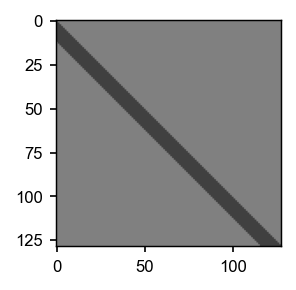

In [14]:
bar_st = st.downsample(ex.stim['mb'][0].astype('double').T, 2)[0].T
bar_st[bar_st == 63] = -0.5
bar_st[bar_st == 127] = 0
plt.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)

In [15]:
df.head()

,exp_id,exp_date,exp_name,exp_version,sort_version_num,retina_idx,intracell_idx,g_cell_num,g_cell_id,flash_1,...,g_2px_binspace_idx_cen_i,i_mb_lin_st_cc_mean,i_mb_lin_line_cc_mean,g_mb_lin_cc_mean_lr,g_mb_lin_cc_mean_rl,g_mb_lin_cc_mean,g_mb_ln_cc_mean_lr,g_mb_ln_cc_mean_rl,g_mb_ln_cc_mean,i_mb_classify_idx
0,0,17-10-18,17-10-18,1,2,1,5,6,0,1,...,67,0.785154,0.685979,0.571053,0.518339,0.544696,0.684928,0.589939,0.637434,7
1,0,17-10-18,17-10-18,1,2,1,5,6,1,1,...,74,0.785154,0.685979,0.495465,0.442066,0.468766,0.563725,0.471638,0.517682,7
2,0,17-10-18,17-10-18,1,2,1,5,6,2,1,...,71,0.785154,0.685979,0.513415,0.493600,0.503507,0.565402,0.534236,0.549819,7
3,0,17-10-18,17-10-18,1,2,1,5,6,3,1,...,61,0.785154,0.685979,0.648359,0.616022,0.632190,0.734976,0.667013,0.700995,7
4,0,17-10-18,17-10-18,1,2,1,5,6,4,1,...,58,0.785154,0.685979,0.419674,0.516071,0.467873,0.507124,0.541078,0.524101,7


In [16]:
re['sample'].keys(), re['bs'].keys(), re['attrs'].keys()

(dict_keys(['gm', 'gmtr', 'im', 'imtr']),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [17]:
re['attrs']['g_list']

Int64Index([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  43,  45,  46,
             47,  48,  51,  52,  54,  55,  56,  57,  58,  66,  68,  69,  70,
             78,  80,  81,  83,  84,  85,  86,  87,  88,  91,  92,  93,  94,
             95,  96,  97, 107, 109, 110, 111, 113, 114, 115, 117, 118, 121,
            122, 124, 126, 127, 128, 129, 130, 132, 134, 135, 136, 138, 139,
            140, 142, 145, 146, 147, 148, 149, 150, 151, 152, 153, 162, 164,
            166, 167, 168, 169, 171, 172, 173, 176, 178, 179, 181, 182, 184,
            185, 186, 187],
           dtype='int64')

## 2. Draw figures

In [18]:
ex_num = 10

(8.5, 19.5, 19.5, 8.5)

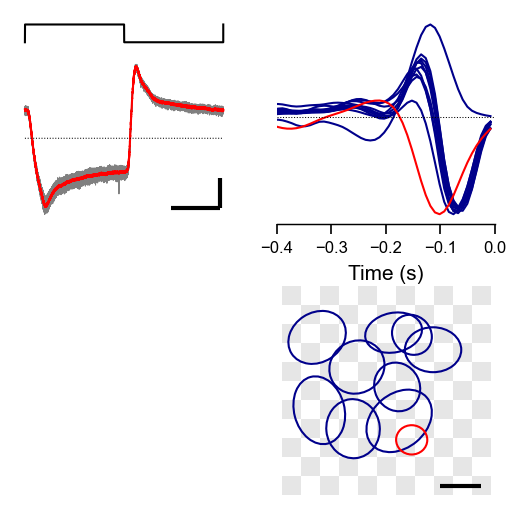

In [19]:
rf_i_st = ex.rf['i']['st'][ex_num]
rf_i_st -= rf_i_st.mean()
rf_i_t = ft.decompose(ft.smooth(rf_i_st, 1, 0))

fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(1, 1), height_ratios=(1, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.2, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.arange(0, 2.0332, 0.0001), ex.i['flash_1'][ex_num][1:, :20332].T, color='gray', linewidth=0.5, alpha=1)
ax1.plot(np.arange(0, 2.0332, 0.0001), np.nanmean(ex.i['flash_1'][ex_num][1:], 0)[:20332], linewidth=1, color='red')
ax1.plot(np.arange(0, 2.0332, 0.0001), 20332 * [np.nanmean(ex.i['flash_1'][ex_num][0, :5])], 'k:', linewidth=0.5)
ax1.plot([1.5, 2], [-45, -45], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax1.plot([2, 2], [-45, -40], 'k', solid_capstyle='butt', linewidth=2)    # 5 mV
ax1.plot(np.arange(0, 2.0332, 0.0001), [-17] + 10165 * [-14] + 10165 * [-17] + [-14], 'k')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
for g in np.array(df[df['exp_id'] == ex_num].index):
    ax2.plot(np.linspace(-0.5-1/120, -1/120, 60), ex.rf['g']['time'][g], color='darkblue', linewidth=1)
ax2.plot(np.linspace(-0.5-1/120, -1/120, 60), rf_i_t[1] * (np.abs(np.stack([ex.rf['g']['time'][g] for g in np.array(df[df['exp_id'] == ex_num].index)])).max() / np.abs(rf_i_t[1]).max()), 'r', linewidth=1)
ax2.axhline(0, color='k', linestyle=":", linewidth=0.5)
ax2.set_xlim([-0.4, 0])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])
ax2.tick_params(size=5)
ax2.set_xlabel('Time (s)', fontsize=10)

ax4 = fig.add_subplot(gs[1, 1])
ax4.imshow(np.tile([[0, 1], [1, 0]], (16, 16)), cmap='gray', alpha=0.1)
for g in np.array(df[df['exp_id'] == ex_num].index):
    ell = Ellipse(xy=ex.rf['g']['ellipse'][g][:2][::-1],
             width=ex.rf['g']['ellipse'][g][2],
             height=ex.rf['g']['ellipse'][g][3],
             angle=-ex.rf['g']['ellipse'][g][4]+90,
             fc = 'none',
             ec='darkblue',
             lw=1)
    ax4.add_artist(ell)
ell = Ellipse(xy=ex.rf['i']['ellipse'][ex_num][:2][::-1],
    width=ex.rf['i']['ellipse'][ex_num][2],
    height=ex.rf['i']['ellipse'][ex_num][3],
    angle=-ex.rf['i']['ellipse'][ex_num][4]+90,
    fc = 'none',
    ec='red',
    lw=1)
ax4.add_artist(ell)
ax4.plot([19-17/8, 19], [19, 19], 'k-', linewidth=2, solid_capstyle='butt')  # 100 microns
ax4.set_xlim([8.5, 19.5])
ax4.set_ylim([19.5, 8.5])
ax4.axis('off')

#plt.savefig('fig_ex10_flash+rf.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [20]:
ex_num = 17

(10.5, 19.5, 18.5, 9.5)

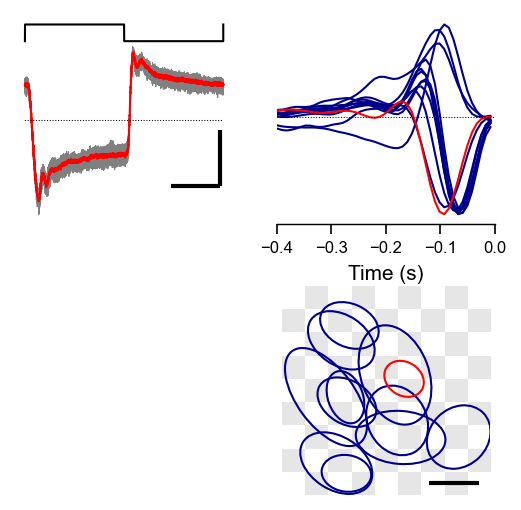

In [21]:
rf_i_st = ex.rf['i']['st'][ex_num]
rf_i_st -= rf_i_st.mean()
rf_i_t = ft.decompose(ft.smooth(rf_i_st, 1, 0))

fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(1, 1), height_ratios=(1, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.2, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.arange(0, 2.0332, 0.0001), ex.i['flash_1'][ex_num][1:, :20332].T, color='gray', linewidth=0.5, alpha=1)
ax1.plot(np.arange(0, 2.0332, 0.0001), np.nanmean(ex.i['flash_1'][ex_num][1:], 0)[:20332], linewidth=1, color='red')
ax1.plot(np.arange(0, 2.0332, 0.0001), 20332 * [np.nanmean(ex.i['flash_1'][ex_num][0, :5])], 'k:', linewidth=0.5)
ax1.plot([1.5, 2], [-10, -10], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax1.plot([2, 2], [-10, -5], 'k', solid_capstyle='butt', linewidth=2)    # 5 mV
ax1.plot(np.arange(0, 2.0332, 0.0001), [3] + 10165 * [4.5] + 10165 * [3] + [4.5], 'k')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
for g in np.array(df[df['exp_id'] == ex_num].index):
    ax2.plot(np.linspace(-0.5-1/120, -1/120, 60), ex.rf['g']['time'][g], color='darkblue', linewidth=1)
ax2.plot(np.linspace(-0.5-1/120, -1/120, 60), rf_i_t[1] * (np.abs(np.stack([ex.rf['g']['time'][g] for g in np.array(df[df['exp_id'] == ex_num].index)])).max() / np.abs(rf_i_t[1]).max()), 'r', linewidth=1)
ax2.axhline(0, color='k', linestyle=":", linewidth=0.5)
ax2.set_xlim([-0.4, 0])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])
ax2.tick_params(size=5)
ax2.set_xlabel('Time (s)', fontsize=10)

ax4 = fig.add_subplot(gs[1, 1])
ax4.imshow(np.tile([[0, 1], [1, 0]], (16, 16)), cmap='gray', alpha=0.1)
for g in np.array(df[df['exp_id'] == ex_num].index):
    ell = Ellipse(xy=ex.rf['g']['ellipse'][g][:2][::-1],
             width=ex.rf['g']['ellipse'][g][2],
             height=ex.rf['g']['ellipse'][g][3],
             angle=-ex.rf['g']['ellipse'][g][4]+90,
             fc = 'none',
             ec='darkblue',
             lw=1)
    ax4.add_artist(ell)
ell = Ellipse(xy=ex.rf['i']['ellipse'][ex_num][:2][::-1],
    width=ex.rf['i']['ellipse'][ex_num][2],
    height=ex.rf['i']['ellipse'][ex_num][3],
    angle=-ex.rf['i']['ellipse'][ex_num][4]+90,
    fc = 'none',
    ec='red',
    lw=1)
ax4.add_artist(ell)
ax4.plot([19-17/8, 19], [18, 18], 'k-', linewidth=2, solid_capstyle='butt')  # 100 microns
ax4.set_xlim([10.5, 19.5])
ax4.set_ylim([18.5, 9.5])
ax4.axis('off')

#plt.savefig('fig_ex17_flash+rf.pdf', bbox_inches='tight', transparent=True, dpi=300)

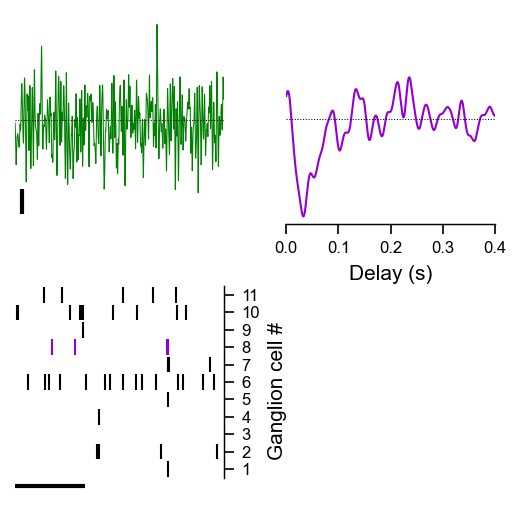

In [22]:
wn_data = ext.txt2array(proj_dir + 'data-figure/18-04-23-sort2/', 77)[1:-1:7]
with h5py.File(proj_dir + '/matrix/wn-500-ao.h5', 'r') as f:
    wn_inj = np.array(f['analog-output'])

fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(1, 1), height_ratios=(1, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.linspace(80, 85, 50000), wn_inj[800000:850000], 'green', linewidth=0.5)
ax1.plot([82.1, 82.1], [-1.4, -1.9], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 nA
ax1.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax1.set_xlim([82, 85])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(-ft.sta(np.linspace(0, 300, 3000000), wn_inj, wn_data[7], 10000)[1], ft.sta(np.linspace(0, 300, 3000000), wn_inj, wn_data[7], 10000)[0], color='darkviolet', linewidth=1)
ax2.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax2.set_xlim([0, 0.4])
ax2.set_ylim([-0.17, 0.17])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])
ax2.tick_params(size=5)
ax2.set_xlabel('Delay (s)', fontsize=10)

ax3 = fig.add_subplot(gs[1, 0])
for g in range(len(wn_data)):
    for s in wn_data[g]:
        if g == 7:
            ax3.plot([s, s], [g+1-0.45, g+1+0.45], color='darkviolet', solid_capstyle='butt', linewidth=1)
        else:
            ax3.plot([s, s], [g+1-0.45, g+1+0.45], 'k', solid_capstyle='butt', linewidth=1)
ax3.plot([82.0, 83.0], [0, 0], 'k', solid_capstyle='butt', linewidth=2)  # 1 s
ax3.set_xlim([82, 85])
ax3.set_ylim([-0.5, 11.5])
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xticks([])
ax3.yaxis.tick_right()
ax3.tick_params(size=5)
ax3.spines['right'].set_bounds(0.5, 11.5)
ax3.yaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 12)))
ax3.set_ylabel('Ganglion cell #', fontsize=10)
ax3.yaxis.set_label_position('right')

#plt.savefig('fig_ex17_transmission.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [23]:
ex.stim['rf_wn'][-1].shape

(72000, 32, 32)

(-0.5, 14.5, 14.5, -0.5)

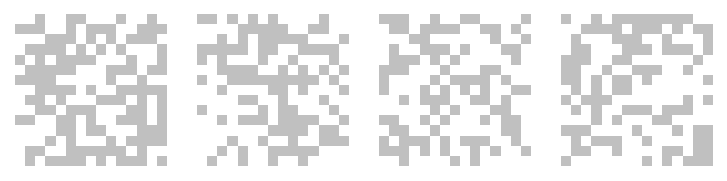

In [24]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(141)
ax.imshow(ex.stim['rf_wn'][-1][0, :15, :15], cmap='gray', alpha=0.25)
ax.axis('off')
ax = plt.subplot(142)
ax.imshow(ex.stim['rf_wn'][-1][8, :15, :15], cmap='gray', alpha=0.25)
ax.axis('off')
ax = plt.subplot(143)
ax.imshow(ex.stim['rf_wn'][-1][16, :15, :15], cmap='gray', alpha=0.25)
ax.axis('off')
ax = plt.subplot(144)
ax.imshow(ex.stim['rf_wn'][-1][24, :15, :15], cmap='gray', alpha=0.25)
ax.axis('off')

#plt.savefig('fig_stim_bin_wn_contrast_reduced.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [25]:
ex_num = 10

In [26]:
rf_color = ['orange', 'darkorange', 'lightgreen', 'darkgreen', 'lightblue', 'darkblue', 'violet', 'pink', 'brown', 'darkgray', 'darkpink']

(0.0, 2.15, 10.5, 0.5)

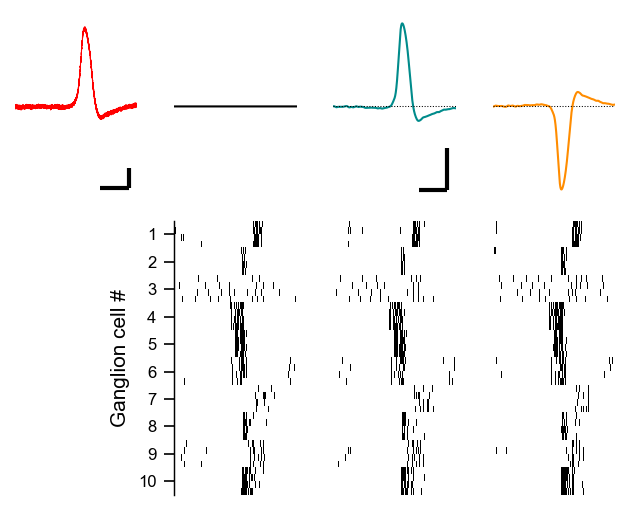

In [27]:
fig = plt.figure(figsize=(5, 4))
gs = fig.add_gridspec(2, 4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1.5), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb'][ex_num][1, 1:, :], 0), 'red', linewidth=0.5)
ax1.plot([2, 2], [-28, -27], 'k', solid_capstyle='butt', linewidth=2)  # 1 mV
ax1.plot([1.5, 2], [-28, -28], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax1.set_xlim([0, 2.149])
ax1.set_ylim([-28.5, -19.2])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 0, :], 0), 'k', linewidth=1)
ax2.set_xlim([0, 2.149])
ax2.set_ylim(-0.55, 0.55)
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 1, :], 0), color='darkcyan', linewidth=1)
ax3.plot([2, 2], [-0.5, -0.25], 'k', solid_capstyle='butt', linewidth=2)  # 0.25 nA
ax3.plot([1.5, 2], [-0.5, -0.5], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax3.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax3.set_xlim([0, 2.149])
ax3.set_ylim(-0.55, 0.55)
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
ax4.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 2, :], 0), color='darkorange', linewidth=1)
ax4.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax4.set_xlim([0, 2.149])
ax4.set_ylim(-0.55, 0.55)
ax4.axis('off')

#ax5 = fig.add_subplot(gs[1, 0])

extent = [0, 129*(1/60), 10.5, 0.5]
ax6 = fig.add_subplot(gs[1, 1])
ax6.imshow(np.stack([ex.g['mb_ad'][g] for g in np.array(df[df['exp_id'] == ex_num].index)])[:, 1, 0, :4].reshape(-1, 129), cmap='gray_r', vmin=0, vmax=1, aspect='auto', interpolation='nearest', extent=extent)
ax6.spines['top'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.tick_params(size=5)
ax6.set_xticks([])
ax6.spines['right'].set_bounds(0.5, 10.5)
ax6.yaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 11)))
ax6.set_ylabel('Ganglion cell #', fontsize=10)

ax7 = fig.add_subplot(gs[1, 2])
ax7.imshow(np.stack([ex.g['mb_ad'][g] for g in np.array(df[df['exp_id'] == ex_num].index)])[:, 1, 1, :4].reshape(-1, 129), cmap='gray_r', vmin=0, vmax=1, aspect='auto', interpolation='nearest', extent=extent)
ax7.axis('off')
ax8 = fig.add_subplot(gs[1, 3])
ax8.imshow(np.stack([ex.g['mb_ad'][g] for g in np.array(df[df['exp_id'] == ex_num].index)])[:, 1, 2, :4].reshape(-1, 129), cmap='gray_r', vmin=0, vmax=1, aspect='auto', interpolation='nearest', extent=extent)
ax8.axis('off')

#plt.savefig('fig_ex10_movingbar.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [28]:
with open(proj_dir + 'data-extract/' + 'sort2' + '/' + '17-11-29' + '_extract_spikes_mb_ad'+ '.p', 'rb') as d:
    spikes_ext_mb_ad = pickle.load(d)

(0.0, 2.149, 0.26999999999999985, 9.73)

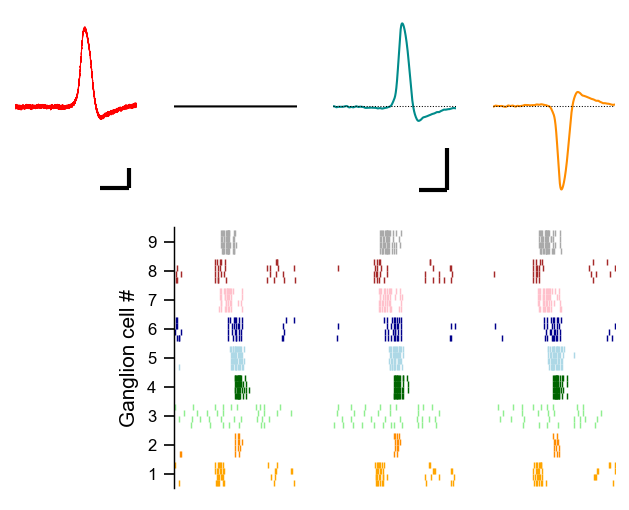

In [29]:
fig = plt.figure(figsize=(5, 4))
gs = fig.add_gridspec(2, 4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1.5), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb'][ex_num][1, 1:, :], 0), 'red', linewidth=0.5)
ax1.plot([2, 2], [-28, -27], 'k', solid_capstyle='butt', linewidth=2)  # 1 mV
ax1.plot([1.5, 2], [-28, -28], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax1.set_xlim([0, 2.149])
ax1.set_ylim([-28.5, -19.2])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 0, :], 0), 'k', linewidth=1)
ax2.set_xlim([0, 2.149])
ax2.set_ylim(-0.55, 0.55)
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 1, :], 0), color='darkcyan', linewidth=1)
ax3.plot([2, 2], [-0.5, -0.25], 'k', solid_capstyle='butt', linewidth=2)  # 0.25 nA
ax3.plot([1.5, 2], [-0.5, -0.5], 'k', solid_capstyle='butt', linewidth=2)  # 0.5 s
ax3.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax3.set_xlim([0, 2.149])
ax3.set_ylim(-0.55, 0.55)
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
ax4.plot(np.linspace(0, 2.15, 21500), np.nanmean(ex.i['mb_ad_ao'][ex_num][1, 2, :], 0), color='darkorange', linewidth=1)
ax4.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax4.set_xlim([0, 2.149])
ax4.set_ylim(-0.55, 0.55)
ax4.axis('off')

#ax5 = fig.add_subplot(gs[1, 0])

ax6 = fig.add_subplot(gs[1, 1])
for g in range(10):
    if g > 6:
        ax6.plot(spikes_ext_mb_ad[g][24+0], [g-0.3]*len(spikes_ext_mb_ad[g][24+0]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+3], [g-0.1]*len(spikes_ext_mb_ad[g][24+3]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+4], [g+0.1]*len(spikes_ext_mb_ad[g][24+4]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+7], [g+0.3]*len(spikes_ext_mb_ad[g][24+7]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
    elif g < 6:
        ax6.plot(spikes_ext_mb_ad[g][24+0], [g+1-0.3]*len(spikes_ext_mb_ad[g][24+0]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+3], [g+1-0.1]*len(spikes_ext_mb_ad[g][24+3]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+4], [g+1+0.1]*len(spikes_ext_mb_ad[g][24+4]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax6.plot(spikes_ext_mb_ad[g][24+7], [g+1+0.3]*len(spikes_ext_mb_ad[g][24+7]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
ax6.set_xlim([0, 2.149])
ax6.spines['top'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.tick_params(size=5)
ax6.set_xticks([])
ax6.spines['left'].set_bounds(0.5, 9.5)
ax6.yaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 11)))
ax6.set_ylabel('Ganglion cell #', fontsize=10)

ax7 = fig.add_subplot(gs[1, 2])
for g in range(10):
    if g > 6:
        ax7.plot(spikes_ext_mb_ad[g][24+0+8], [g-0.3]*len(spikes_ext_mb_ad[g][24+0+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+3+8], [g-0.1]*len(spikes_ext_mb_ad[g][24+3+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+4+8], [g+0.1]*len(spikes_ext_mb_ad[g][24+4+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+7+8], [g+0.3]*len(spikes_ext_mb_ad[g][24+7+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
    elif g < 6:
        ax7.plot(spikes_ext_mb_ad[g][24+0+8], [g+1-0.3]*len(spikes_ext_mb_ad[g][24+0+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+3+8], [g+1-0.1]*len(spikes_ext_mb_ad[g][24+3+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+4+8], [g+1+0.1]*len(spikes_ext_mb_ad[g][24+4+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax7.plot(spikes_ext_mb_ad[g][24+7+8], [g+1+0.3]*len(spikes_ext_mb_ad[g][24+7+8]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
ax7.set_xlim([0, 2.149])
ax7.spines['left'].set_bounds(0.5, 9.5)
ax7.axis('off')

ax8 = fig.add_subplot(gs[1, 3])
for g in range(10):
    if g > 6:
        ax8.plot(spikes_ext_mb_ad[g][24+0+16], [g-0.3]*len(spikes_ext_mb_ad[g][24+0+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+3+16], [g-0.1]*len(spikes_ext_mb_ad[g][24+3+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+4+16], [g+0.1]*len(spikes_ext_mb_ad[g][24+4+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+7+16], [g+0.3]*len(spikes_ext_mb_ad[g][24+7+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
    elif g < 6:
        ax8.plot(spikes_ext_mb_ad[g][24+0+16], [g+1-0.3]*len(spikes_ext_mb_ad[g][24+0+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+3+16], [g+1-0.1]*len(spikes_ext_mb_ad[g][24+3+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+4+16], [g+1+0.1]*len(spikes_ext_mb_ad[g][24+4+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
        ax8.plot(spikes_ext_mb_ad[g][24+7+16], [g+1+0.3]*len(spikes_ext_mb_ad[g][24+7+16]), '|', markersize=2.5, mew=0.7, color=rf_color[g])
ax8.set_xlim([0, 2.149])
ax8.spines['left'].set_bounds(0.5, 9.5)
ax8.axis('off')

#plt.savefig('fig_ex10_movingbar_raster.pdf', bbox_inches='tight', transparent=True, dpi=300)

(8.5, 18.5, 19.5, 9.5)

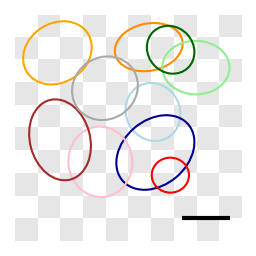

In [30]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.imshow(np.tile([[0, 1], [1, 0]], (16, 16)), cmap='gray', alpha=0.1)
for g in np.array(df[df['exp_id'] == ex_num].index):
    ell = Ellipse(xy=ex.rf['g']['ellipse'][g][:2][::-1],
             width=ex.rf['g']['ellipse'][g][2],
             height=ex.rf['g']['ellipse'][g][3],
             angle=-ex.rf['g']['ellipse'][g][4]+90,
             fc = 'none',
             ec=rf_color[g-106],
             lw=1)
    ax.add_artist(ell)
ell = Ellipse(xy=ex.rf['i']['ellipse'][ex_num][:2][::-1],
    width=ex.rf['i']['ellipse'][ex_num][2],
    height=ex.rf['i']['ellipse'][ex_num][3],
    angle=-ex.rf['i']['ellipse'][ex_num][4]+90,
    fc = 'none',
    ec='red',
    lw=1)
ax.add_artist(ell)
ax.plot([18-17/8, 18], [18.5, 18.5], 'k-', linewidth=2, solid_capstyle='butt')  # 100 microns
ax.set_xlim([8.5, 18.5])
ax.set_ylim([19.5, 9.5])
ax.axis('off')

#plt.savefig('fig_ex10_rf_space_color.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [31]:
N = re['attrs']['N']
print(N)

1000


In [32]:
i2s = lambda g: 2 * (100/17) * (g - 63.5)

In [33]:
clip = lambda f, c: f[((f>c[0]) & (f<c[1]))]

In [34]:
sm_sigma_s = 3
sm_sigma_t = 2
peak_con_1_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['1']['con'], 0)) for n in range(N)])
peak_con_2_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['2']['con'], 0)) for n in range(N)])
peak_con_4_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['4']['con'], 0)) for n in range(N)])
peak_con_all_s = np.stack([np.argmax(np.nanmean(re['bs'][n]['gmtr']['c']['all']['con'], 0)) for n in range(N)])
peak_diff_1_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s)) for n in range(N)])
peak_diff_2_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s)) for n in range(N)])
peak_diff_4_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 0), sm_sigma_s)) for n in range(N)])
peak_diff_all_s = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s)) for n in range(N)])
#peak_diff_1_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 1), sm_sigma_t)) for n in range(N)])
#peak_diff_2_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 1), sm_sigma_t)) for n in range(N)])
#peak_diff_4_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 1), sm_sigma_t)) for n in range(N)])
#peak_diff_all_t = np.stack([np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t)) for n in range(N)])

In [35]:
com_con_1_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['1']['con'], 0))[0] for n in range(N)])
com_con_2_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['2']['con'], 0))[0] for n in range(N)])
com_con_4_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['4']['con'], 0))[0] for n in range(N)])
com_con_all_s = np.stack([scipy.ndimage.center_of_mass(np.nanmean(re['bs'][n]['gmtr']['c']['all']['con'], 0))[0] for n in range(N)])
com_diff_1_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
com_diff_2_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
com_diff_4_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['4']['diff'], 0), sm_sigma_s))[0] for n in range(N)])
com_diff_all_s = np.stack([scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0] for n in range(N)])

In [36]:
peak_shift_edge_all_s = i2s(peak_diff_all_s)
com_shift_edge_all_s = i2s(com_diff_all_s)

peak_shift_all_s = i2s(peak_diff_all_s) - i2s(peak_con_all_s)
com_shift_all_s = i2s(com_diff_all_s) - i2s(com_con_all_s)

In [37]:
print(i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))), i2s(peak_con_all_s).std()) # not a normal dist
print(i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))[0]), i2s(com_con_all_s).std())

-17.647058823529413 9.358488920701502
-50.00939136773786 5.303860758503812


In [38]:
print(i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))), i2s(peak_diff_all_s).std())  # not a normal dist
print(i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0))[0]), i2s(com_diff_all_s).std())

41.1764705882353 24.12263649967602
-0.5081361861423476 135.40856754538794


In [39]:
peak_shift_all_s_sample = i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))) - i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0)))
print(peak_shift_all_s_sample, np.percentile(peak_shift_all_s - peak_shift_all_s.mean(), [2.5, 97.5]) + peak_shift_all_s_sample)
print('<0.05')
#print(scipy.stats.t.sf(np.abs(peak_shift_all_s_sample/np.nanstd(peak_shift_all_s)), (2 * len(re['attrs']['g_list']) - 1)) * 2) # two-tailed

58.82352941176471 [11.22352941 93.57647059]
<0.05


In [40]:
com_shift_all_s_sample = i2s(scipy.ndimage.center_of_mass(-smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0]) - i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))[0])
print(com_shift_all_s_sample, np.percentile(com_shift_all_s - com_shift_all_s.mean(), [2.5, 97.5]) + com_shift_all_s_sample)
print(com_shift_all_s_sample, np.percentile(com_shift_all_s - com_shift_all_s.mean(), [30, 70]) + com_shift_all_s_sample)
print('<0.6')

49.40935173706587 [-64.97945643 222.87139588]
49.40935173706587 [ 7.4166531  64.46216632]
<0.6


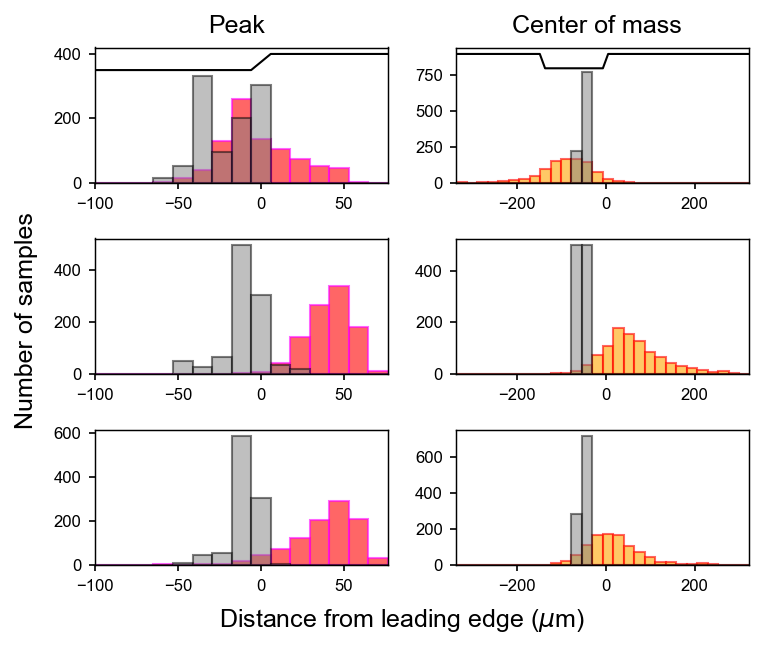

In [41]:
slim1 = (i2s(55), i2s(70))
slim2 = (i2s(35), i2s(91))

fig = plt.figure(figsize=(5, 4))
fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.5, 'Number of samples', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0.28, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
fig.text(0.76, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax = plt.subplot(321)
ax.plot(sbins, np.nanmean(tr(bar_st), 0)*100 + 400, 'k')
ax.hist(i2s(peak_diff_1_s), 15, slim1, color='red', edgecolor='magenta', alpha=0.6)
ax.hist(i2s(peak_con_1_s), 15, slim1, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim1)
ax = plt.subplot(323)
ax.hist(i2s(peak_diff_2_s), 15, slim1, color='red', edgecolor='magenta', alpha=0.6)
ax.hist(i2s(peak_con_2_s), 15, slim1, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim1)
ax = plt.subplot(325)
ax.hist(i2s(peak_diff_all_s), 15, slim1, color='red', edgecolor='magenta', alpha=0.6)
ax.hist(i2s(peak_con_all_s), 15, slim1, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim1)

ax = plt.subplot(322)
ax.plot(sbins, np.nanmean(tr(bar_st), 0)*200 + 900, 'k')
ax.hist(i2s(com_diff_1_s), 28, slim2, color='orange', edgecolor='red', alpha=0.6)
ax.hist(i2s(com_con_1_s), 28, slim2, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim2)
ax = plt.subplot(324)
ax.hist(i2s(com_diff_2_s), 28, slim2, color='orange', edgecolor='red', alpha=0.6)
ax.hist(i2s(com_con_2_s), 28, slim2, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim2)
ax = plt.subplot(326)
ax.hist(i2s(com_diff_all_s), 28, slim2, color='orange', edgecolor='red', alpha=0.6)
ax.hist(i2s(com_con_all_s), 28, slim2, color='gray', edgecolor='k', alpha=0.5)
ax.set_xlim(slim2)

plt.tight_layout()

#plt.savefig('fig_c01_peak+com+histogram', bbox_inches='tight', dpi=300)

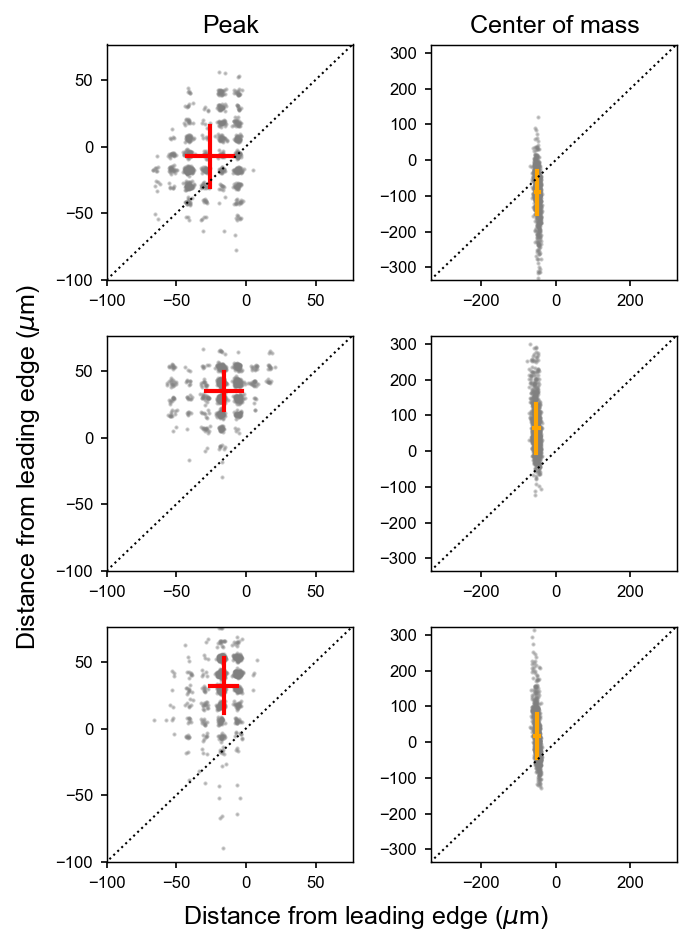

In [42]:
fig = plt.figure(figsize=(4.5, 6))

fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.5, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90)
fig.text(0.3, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
fig.text(0.78, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax1 = plt.subplot(321)
ax1.plot(i2s(peak_con_1_s)+np.random.normal(0, 1.5, re['attrs']['N']), i2s(peak_diff_1_s)+np.random.normal(0, 1.5, re['attrs']['N']), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax1.plot([np.mean(clip(i2s(peak_con_1_s), slim1)), np.mean(clip(i2s(peak_con_1_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_1_s), slim1))-np.std(clip(i2s(peak_diff_1_s), slim1)), 
          np.mean(clip(i2s(peak_diff_1_s), slim1))+np.std(clip(i2s(peak_diff_1_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax1.plot([np.mean(clip(i2s(peak_con_1_s), slim1))-np.std(clip(i2s(peak_con_1_s), slim1)), 
          np.mean(clip(i2s(peak_con_1_s), slim1))+np.std(clip(i2s(peak_con_1_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_1_s), slim1)), np.mean(clip(i2s(peak_diff_1_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax1.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax1.set_xlim(slim1)
ax1.set_ylim(slim1)

ax2 = plt.subplot(322)
ax2.plot(i2s(com_con_1_s), i2s(com_diff_1_s), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax2.plot([np.mean(clip(i2s(com_con_1_s), slim2)), np.mean(clip(i2s(com_con_1_s), slim2))], 
         [np.mean(clip(i2s(com_diff_1_s), slim2))-np.std(clip(i2s(com_diff_1_s), slim2)), 
          np.mean(clip(i2s(com_diff_1_s), slim2))+np.std(clip(i2s(com_diff_1_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax2.plot([np.mean(clip(i2s(com_con_1_s), slim2))-np.std(clip(i2s(com_con_1_s), slim2)), 
          np.mean(clip(i2s(com_con_1_s), slim2))+np.std(clip(i2s(com_con_1_s), slim2))], 
         [np.mean(clip(i2s(com_diff_1_s), slim2)), np.mean(clip(i2s(com_diff_1_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax2.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax2.set_xlim(slim2)
ax2.set_ylim(slim2)

ax3 = plt.subplot(323)
ax3.plot(i2s(peak_con_2_s)+np.random.normal(0, 1.5, re['attrs']['N']), i2s(peak_diff_2_s)+np.random.normal(0, 1.5, re['attrs']['N']), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax3.plot([np.mean(clip(i2s(peak_con_2_s), slim1)), np.mean(clip(i2s(peak_con_2_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_2_s), slim1))-np.std(clip(i2s(peak_diff_2_s), slim1)), 
          np.mean(clip(i2s(peak_diff_2_s), slim1))+np.std(clip(i2s(peak_diff_2_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax3.plot([np.mean(clip(i2s(peak_con_2_s), slim1))-np.std(clip(i2s(peak_con_2_s), slim1)), 
          np.mean(clip(i2s(peak_con_2_s), slim1))+np.std(clip(i2s(peak_con_2_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_2_s), slim1)), np.mean(clip(i2s(peak_diff_2_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax3.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax3.set_xlim(slim1)
ax3.set_ylim(slim1)

ax4 = plt.subplot(324)
ax4.plot(i2s(com_con_2_s), i2s(com_diff_2_s), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax4.plot([np.mean(clip(i2s(com_con_2_s), slim2)), np.mean(clip(i2s(com_con_2_s), slim2))], 
         [np.mean(clip(i2s(com_diff_2_s), slim2))-np.std(clip(i2s(com_diff_2_s), slim2)), 
          np.mean(clip(i2s(com_diff_2_s), slim2))+np.std(clip(i2s(com_diff_2_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax4.plot([np.mean(clip(i2s(com_con_2_s), slim2))-np.std(clip(i2s(com_con_2_s), slim2)), 
          np.mean(clip(i2s(com_con_2_s), slim2))+np.std(clip(i2s(com_con_2_s), slim2))], 
         [np.mean(clip(i2s(com_diff_2_s), slim2)), np.mean(clip(i2s(com_diff_2_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax4.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax4.set_xlim(slim2)
ax4.set_ylim(slim2)

ax5 = plt.subplot(325)
ax5.plot(i2s(peak_con_all_s)+np.random.normal(0, 1.5, re['attrs']['N']), i2s(peak_diff_all_s)+np.random.normal(0, 1.5, re['attrs']['N']), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax5.plot([np.mean(clip(i2s(peak_con_all_s), slim1)), np.mean(clip(i2s(peak_con_all_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_all_s), slim1))-np.std(clip(i2s(peak_diff_all_s), slim1)), 
          np.mean(clip(i2s(peak_diff_all_s), slim1))+np.std(clip(i2s(peak_diff_all_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax5.plot([np.mean(clip(i2s(peak_con_all_s), slim1))-np.std(clip(i2s(peak_con_all_s), slim1)), 
          np.mean(clip(i2s(peak_con_all_s), slim1))+np.std(clip(i2s(peak_con_all_s), slim1))], 
         [np.mean(clip(i2s(peak_diff_all_s), slim1)), np.mean(clip(i2s(peak_diff_all_s), slim1))],
        color='red', linestyle='-', linewidth=2)
ax5.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax5.set_xlim(slim1)
ax5.set_ylim(slim1)

ax6 = plt.subplot(326)
ax6.plot(i2s(com_con_all_s), i2s(com_diff_all_s), 
        color='gray', linestyle='', marker='.', markersize=2, alpha=0.4)
ax6.plot([np.mean(clip(i2s(com_con_all_s), slim2)), np.mean(clip(i2s(com_con_all_s), slim2))], 
         [np.mean(clip(i2s(com_diff_all_s), slim2))-np.std(clip(i2s(com_diff_all_s), slim2)), 
          np.mean(clip(i2s(com_diff_all_s), slim2))+np.std(clip(i2s(com_diff_all_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax6.plot([np.mean(clip(i2s(com_con_all_s), slim2))-np.std(clip(i2s(com_con_all_s), slim2)), 
          np.mean(clip(i2s(com_con_all_s), slim2))+np.std(clip(i2s(com_con_all_s), slim2))], 
         [np.mean(clip(i2s(com_diff_all_s), slim2)), np.mean(clip(i2s(com_diff_all_s), slim2))],
        color='orange', linestyle='-', linewidth=2)
ax6.plot(np.arange(-400, 400), np.arange(-400, 400), 'k:')
ax6.set_xlim(slim2)
ax6.set_ylim(slim2)

plt.draw()
plt.tight_layout()

#plt.savefig('fig_c01_peak+com+scatter', bbox_inches='tight', dpi=300)

In [43]:
#slim1_d = (-90, 300)
#slim2_d = (-400, 500)
slim1_d = (-100, 300)
slim2_d = (-400, 500)

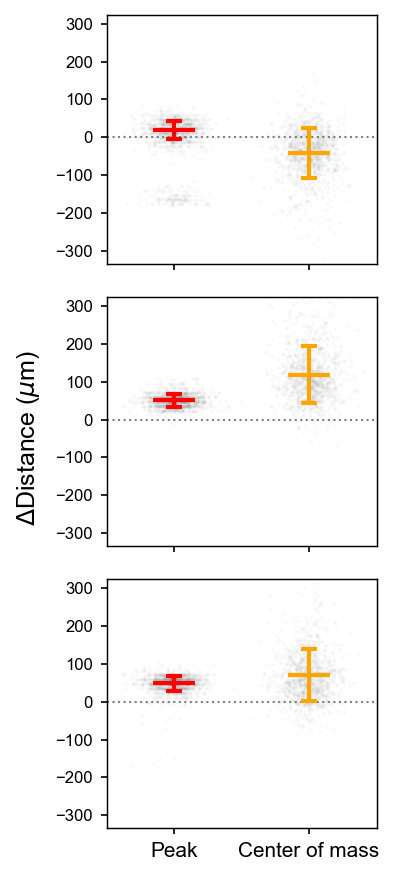

In [44]:
fig = plt.figure(figsize=(2.5, 6))

#fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.5, '$\Delta$Distance ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90)
#fig.text(0.3, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
#fig.text(0.78, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax1 = plt.subplot(311)
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.plot(np.random.normal(0, 0.12, re['attrs']['N']), i2s(peak_diff_1_s) - i2s(peak_con_1_s) + np.random.normal(0, 2, re['attrs']['N']), color='gray', linestyle='', marker='.', alpha=0.03)
ax1.errorbar(0, np.mean(clip(i2s(peak_diff_1_s) - i2s(peak_con_1_s), slim1_d)), yerr=np.std(clip(i2s(peak_diff_1_s) - i2s(peak_con_1_s), slim1_d)), 
             fmt='r_', markersize=20, mew=2, ecolor='red', elinewidth=2, capsize=4)
ax1.plot(np.random.normal(1, 0.12, re['attrs']['N']), i2s(com_diff_1_s) - i2s(com_con_1_s), color='gray', linestyle='', marker='.', alpha=0.03)
ax1.errorbar(1, np.mean(clip(i2s(com_diff_1_s) - i2s(com_con_1_s), slim2_d)), yerr=np.std(clip(i2s(com_diff_1_s) - i2s(com_con_1_s), slim2_d)), 
             color='orange', marker='_', markersize=20, mew=2, ecolor='orange', elinewidth=2, capsize=4)
ax1.set_xlim((-0.5, 1.5))
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['', ''])
ax1.set_ylim(slim2)

ax2 = plt.subplot(312)
ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
ax2.plot(np.random.normal(0, 0.12, re['attrs']['N']), i2s(peak_diff_2_s) - i2s(peak_con_2_s) + np.random.normal(0, 2, re['attrs']['N']), color='gray', linestyle='', marker='.', alpha=0.03)
ax2.errorbar(0, np.mean(clip(i2s(peak_diff_2_s) - i2s(peak_con_2_s), slim1_d)), yerr=np.std(clip(i2s(peak_diff_2_s) - i2s(peak_con_2_s), slim1_d)), 
             fmt='r_', markersize=20, mew=2, ecolor='red', elinewidth=2, capsize=4)
ax2.plot(np.random.normal(1, 0.12, re['attrs']['N']), i2s(com_diff_2_s) - i2s(com_con_2_s), color='gray', linestyle='', marker='.', alpha=0.03)
ax2.errorbar(1, np.mean(clip(i2s(com_diff_2_s) - i2s(com_con_2_s), slim2_d)), yerr=np.std(clip(i2s(com_diff_2_s) - i2s(com_con_2_s), slim2_d)), 
             color='orange', marker='_', markersize=20, mew=2, ecolor='orange', elinewidth=2, capsize=4)
ax2.set_xlim((-0.5, 1.5))
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['', ''])
ax2.set_ylim(slim2)

ax3 = plt.subplot(313)
ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
ax3.plot(np.random.normal(0, 0.12, re['attrs']['N']), i2s(peak_diff_all_s) - i2s(peak_con_all_s) + np.random.normal(0, 2, re['attrs']['N']), color='gray', linestyle='', marker='.', alpha=0.03)
ax3.errorbar(0, np.mean(clip(i2s(peak_diff_all_s) - i2s(peak_con_all_s), slim1_d)), yerr=np.std(clip(i2s(peak_diff_all_s) - i2s(peak_con_all_s), slim1_d)), 
             fmt='r_', markersize=20, mew=2, ecolor='red', elinewidth=2, capsize=4)
ax3.plot(np.random.normal(1, 0.12, re['attrs']['N']), i2s(com_diff_all_s) - i2s(com_con_all_s), color='gray', linestyle='', marker='.', alpha=0.03)
ax3.errorbar(1, np.mean(clip(i2s(com_diff_all_s) - i2s(com_con_all_s), slim2_d)), yerr=np.std(clip(i2s(com_diff_all_s) - i2s(com_con_all_s), slim2_d)), 
             color='orange', marker='_', markersize=20, mew=2, ecolor='orange', elinewidth=2, capsize=4)
ax3.set_xlim((-0.5, 1.5))
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Peak', 'Center of mass'], fontsize=10, rotation=0)
ax3.set_ylim(slim2)

plt.tight_layout()

In [45]:
peak_delta_1 = clip(i2s(peak_diff_1_s) - i2s(peak_con_1_s), slim1_d)
peak_delta_2 = clip(i2s(peak_diff_2_s) - i2s(peak_con_2_s), slim1_d)
peak_delta_all = clip(i2s(peak_diff_all_s) - i2s(peak_con_all_s), slim1_d)
com_delta_1 = clip(i2s(com_diff_1_s) - i2s(com_con_1_s), slim2_d)
com_delta_2 = clip(i2s(com_diff_2_s) - i2s(com_con_2_s), slim2_d)
com_delta_all = clip(i2s(com_diff_all_s) - i2s(com_con_all_s), slim2_d)

In [46]:
sample_peak_delta_1 = (i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['1']['diff'], 0), sm_sigma_s))) - 
                       i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['1']['con'], 0))))
sample_peak_delta_2 = (i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['2']['diff'], 0), sm_sigma_s))) - 
                       i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['2']['con'], 0))))
sample_peak_delta_all = (i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))) - 
                         i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))))
sample_com_delta_1 = (i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['1']['diff'], 0), sm_sigma_s))[0]) - 
                      i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['1']['con'], 0))[0]))
sample_com_delta_2 = (i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['2']['diff'], 0), sm_sigma_s))[0]) - 
                      i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['2']['con'], 0))[0]))
sample_com_delta_all = (i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0]) - 
                        i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))[0]))

In [47]:
print('Confidence interval of delta peak and delta com from ganglion cell firing rate and firing rate change')
#print(np.percentile(peak_delta_1 - peak_delta_1.mean() + np.random.normal(0, 0.01, peak_delta_1.shape[0]), [2.5, 97.5]) + sample_peak_delta_1)
#print(np.percentile(peak_delta_2 - peak_delta_2.mean() + np.random.normal(0, 0.01, peak_delta_2.shape[0]), [2.5, 97.5]) + sample_peak_delta_2)
print(np.percentile(peak_delta_all - peak_delta_all.mean() + np.random.normal(0, 0.01, peak_delta_all.shape[0]), [2.5, 97.5]) + sample_peak_delta_all)  # bias correction
#print(np.percentile(com_delta_1 - com_delta_1.mean(), [2.5, 97.5]) + sample_com_delta_1)
#print(np.percentile(com_delta_2 - com_delta_2.mean(), [2.5, 97.5]) + sample_com_delta_2)
print(np.percentile(com_delta_all - com_delta_all.mean(), [2.5, 97.5]) + sample_com_delta_all)

Confidence interval of delta peak and delta com from ganglion cell firing rate and firing rate change
[10.39694979 92.74481134]
[-59.36364126 217.41245422]


In [48]:
t_peak_1 = (sample_peak_delta_1 - 0)/np.nanstd(peak_delta_1)
t_peak_2 = (sample_peak_delta_2 - 0)/np.nanstd(peak_delta_2)
t_peak_all = (sample_peak_delta_all - 0)/np.nanstd(peak_delta_all)
t_com_1 = (sample_com_delta_1 - 0)/np.nanstd(com_delta_1)
t_com_2 = (sample_com_delta_2 - 0)/np.nanstd(com_delta_2)
t_com_all = (sample_com_delta_all - 0)/np.nanstd(com_delta_all)

In [49]:
np.abs(t_peak_all)

2.869284418817194

In [50]:
print('p-value of two-tailed t-test peak / com')
#print(scipy.stats.t.sf(np.abs(t_peak_1), (2 * len(re['attrs']['g_list']) - 1)) * 2)
#print(scipy.stats.t.sf(np.abs(t_peak_2), (2 * len(re['attrs']['g_list']) - 1)) * 2)
print(scipy.stats.t.sf(np.abs(t_peak_all), (2 * len(re['attrs']['g_list']) - 1)) * 2) # two-tailed
#print(scipy.stats.t.sf(np.abs(t_com_1), (2 * len(re['attrs']['g_list']) - 1)) * 2)
#print(scipy.stats.t.sf(np.abs(t_com_2), (2 * len(re['attrs']['g_list']) - 1)) * 2)
print(scipy.stats.t.sf(np.abs(t_com_all), (2 * len(re['attrs']['g_list']) - 1)) * 2)

p-value of two-tailed t-test peak / com
0.00458749249250728
0.4737965331309


In [51]:
bar_speed = 2 * (100/17) / (1/(60)) #(um/s)
bar_speed

705.8823529411766

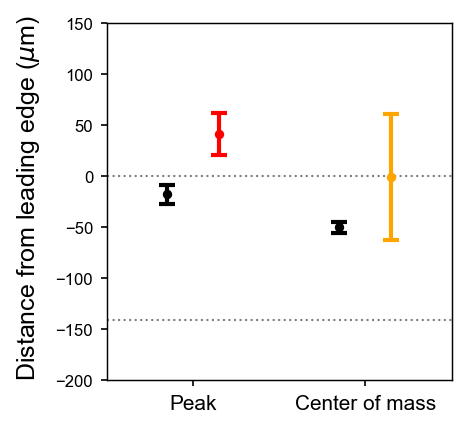

In [52]:
fig = plt.figure(figsize=(3, 3))

#fig.text(0.5, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center')
fig.text(0, 0.54, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90)
#fig.text(0.3, 0.99, 'Peak', verticalalignment='center', horizontalalignment='center')
#fig.text(0.78, 0.99, 'Center of mass', verticalalignment='center', horizontalalignment='center')

ax = plt.subplot(111)
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axhline(-24 * (100/17), color='gray', linestyle=':', linewidth=1)


#ax.errorbar(0, np.mean(clip(i2s(peak_diff_all_s) - i2s(peak_con_all_s), slim1_d)), yerr=np.std(clip(i2s(peak_diff_all_s) - i2s(peak_con_all_s), slim1_d)), 
#             fmt='r_', markersize=20, mew=2, ecolor='red', elinewidth=2, capsize=4)
#ax.errorbar(1, np.mean(clip(i2s(com_diff_all_s) - i2s(com_con_all_s), slim2_d)), yerr=np.std(clip(i2s(com_diff_all_s) - i2s(com_con_all_s), slim2_d)), 
#             color='orange', marker='_', markersize=20, mew=2, ecolor='orange', elinewidth=2, capsize=4)

ax.errorbar(-0.15, i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))), yerr=np.nanstd(clip(i2s(peak_con_all_s), slim1)), fmt='k.', markersize=5, mew=2, ecolor='black', elinewidth=2, capsize=4)
ax.errorbar(0.15, i2s(np.argmin(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))), yerr=np.nanstd(clip(i2s(peak_diff_all_s), slim1)), fmt='r.', markersize=5, mew=2, ecolor='red', elinewidth=2, capsize=4)

ax.errorbar(1-0.15, i2s(scipy.ndimage.center_of_mass(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))[0]), yerr=np.nanstd(clip(i2s(com_con_all_s), slim2)), fmt='k.', markersize=5, mew=2, ecolor='black', elinewidth=2, capsize=4)
ax.errorbar(1+0.15, i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0]), yerr=np.nanstd(clip(i2s(com_diff_all_s), slim2)), color='orange', marker='.', markersize=5, mew=2, ecolor='orange', elinewidth=2, capsize=4)

ax.set_xlim((-0.5, 1.5))
ax.set_xticks([0, 1])
ax.set_xticklabels(['Peak', 'Center of mass'], fontsize=10, rotation=0)
ax.set_ylim([-200, 150])

plt.tight_layout()

#plt.savefig('fig_c01_peak+com+shift', bbox_inches='tight', dpi=300)

In [53]:
print('peak shift of ganglion cell from linear-nonlinear model (in barspace, [um], mean += sem (estimated from bootstrap s.d.))')
print(i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))) - i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['ln']['con'], 0))))
print(np.std(i2s(peak_con_all_s)))
print('which is in time (ms)')
print(1000*(i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['all']['con'], 0))) - i2s(np.argmax(np.nanmean(re['sample']['gmtr']['c']['ln']['con'], 0))))/bar_speed)

peak shift of ganglion cell from linear-nonlinear model (in barspace, [um], mean += sem (estimated from bootstrap s.d.))
70.58823529411765
9.358488920701502
which is in time (ms)
99.99999999999999


In [54]:
sm_sigma_s = 4
sm_sigma_t = 2

In [55]:
li = 'all'
m_raw = re['sample']['gmtr']['c'][li]['diff']
m_raw_st = re['sample']['gm']['c'][li]['diff']
m_smooth = smooth(nn(m_raw), sm_sigma_t-0.5, sm_sigma_s-0.5)
m_smooth_st = smooth(nn(m_raw_st), sm_sigma_t-0.5, sm_sigma_s-0.5)
m_s = smooth_1d(np.nanmean(m_raw, 0), sm_sigma_s-0.5)
m_t = smooth_1d(np.nanmean(m_raw, 1), sm_sigma_t-0.5)

#ma_s = smooth_1d(np.nanmean(smooth(nn(re['sample']['gmtr']['c'][li]['amp_con']), sm_sigma_t, sm_sigma_s), 0), sm_sigma_s)
#md_s = smooth_1d(np.nanmean(smooth(nn(re['sample']['gmtr']['c'][li]['dim_con']), sm_sigma_t, sm_sigma_s), 0), sm_sigma_s)

mg_raw_st = re['sample']['gm']['c'][li]['con']
mg_raw = re['sample']['gmtr']['c'][li]['con']
mg_s = np.nanmean(mg_raw, 0)
b = tr(bar_st)
extent = (-128*(100/17), 128*(100/17), 129*(1/60)/2, -129*(1/60)/2)
extent2 = (-129*(1/60)/2, 129*(1/60)/2, -128*(100/17), 128*(100/17))

(0.4, -0.3)

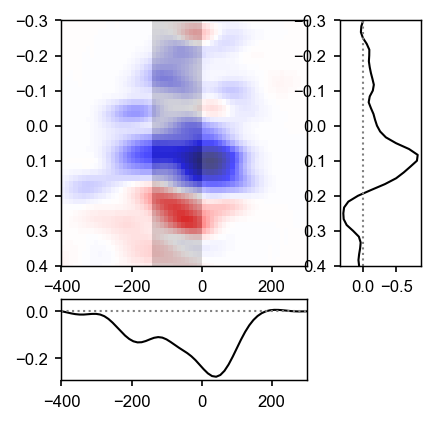

In [56]:
fig = plt.figure(figsize=(3, 3))
gs = fig.add_gridspec(2, 2, width_ratios=(3, 1), height_ratios=(3, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(m_smooth, cmap='seismic', vmin=-np.max(abs(nn(m_smooth))), vmax=np.max(abs(nn(m_smooth))), aspect='auto', interpolation='nearest', extent=extent)
ax1.imshow(b, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent)
ax1.set_xlim((-400, 300))
ax1.set_ylim((0.4, -0.3))

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(sbins, m_s, 'k')
ax2.axhline(0, color='gray', linestyle=':')
ax2.set_xlim((-400, 300))

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(m_t, tbins, 'k')
ax3.axvline(0, color='gray', linestyle=':')
ax3.set_xlim(ax3.get_xlim()[::-1])
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_ylim((0.4, -0.3))

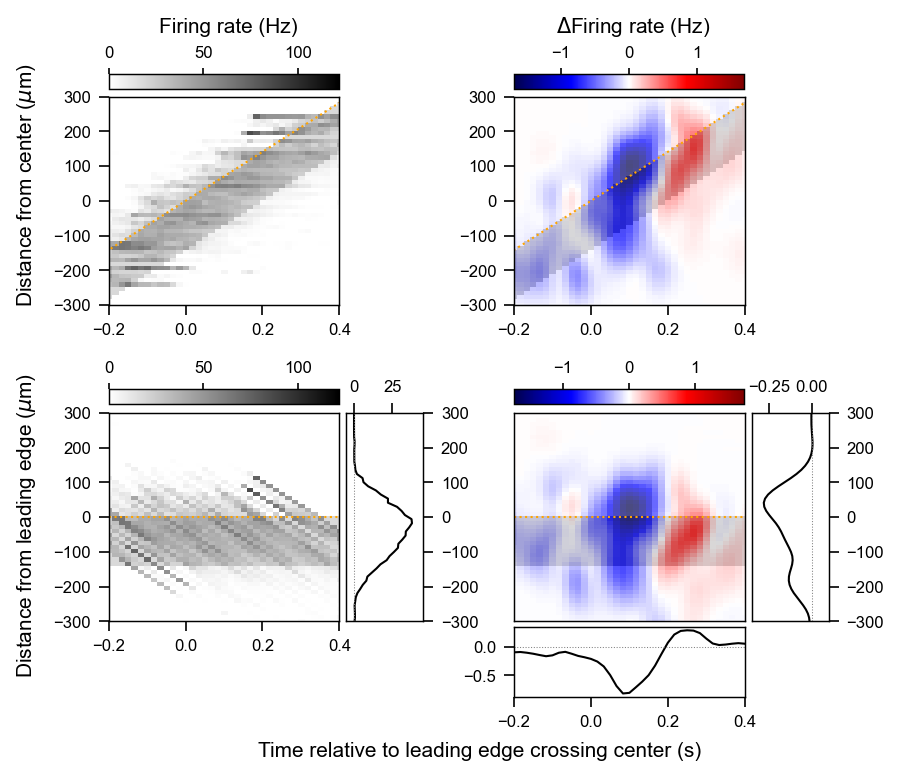

In [57]:
fig = plt.figure(figsize=(6, 5))
plt.text(0.5, -0.13, 'Time relative to leading edge crossing center (s)', verticalalignment='center', horizontalalignment='center', fontsize=10)
plt.text(-0.15, 0.87, 'Distance from center ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
plt.text(-0.15, 0.27, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
plt.text(0.14, 1.15, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', fontsize=10)
plt.text(0.72, 1.15, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', fontsize=10)
plt.axis('off')
gs = fig.add_gridspec(5, 5, width_ratios=(3, 1, 1, 3, 1), height_ratios=(3, 1, 0.3, 3, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.05, hspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(nn(mg_raw_st)[:, ::-1].T, cmap='gray_r', vmin=0, vmax=np.max(abs(nn(mg_raw_st))), aspect='auto', interpolation='nearest', extent=extent2)
ax1_cb = plt.axes([.1, 0.91, .256, .02])
cb1 = plt.colorbar(im1, cax=ax1_cb, orientation='horizontal')
ax1_cb.xaxis.set_ticks_position('top')
ax1.imshow(bar_st[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax1.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17), color='orange', linestyle=':', linewidth=1)
ax1.set_xlim((-0.2, 0.4))
ax1.set_ylim((-300, 300))
ax1.tick_params(size=5)
#ax1.set_xticks([])
#ax1.set_yticks([])

#ax2 = fig.add_subplot(gs[1, 0])

#ax3 = fig.add_subplot(gs[0, 1])

ax5 = fig.add_subplot(gs[0, 3])
im2 = ax5.imshow(m_smooth_st[:, ::-1].T, cmap='seismic', vmin=-np.max(abs(nn(m_smooth_st))), vmax=np.max(abs(nn(m_smooth_st))), aspect='auto', interpolation='nearest', extent=extent2)
ax5_cb = plt.axes([.55, 0.91, .256, .02])
cb2 = plt.colorbar(im2, cax=ax5_cb, orientation='horizontal')
ax5_cb.xaxis.set_ticks_position('top')
ax5.imshow(bar_st[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax5.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17), color='orange', linestyle=':', linewidth=1)
ax5.set_xlim((-0.2, 0.4))
ax5.set_ylim((-300, 300))
ax5.tick_params(size=5)
#ax5.set_xticks([])
#ax5.set_yticks([])

#ax6 = fig.add_subplot(gs[1, 3])
#ax6.plot(tbins, m_t, 'k', linewidth=1.5)
#ax6.axhline(0, color='gray', linestyle=':', linewidth=2)
#ax6.set_xlim((-0.2, 0.4))
#ax6.set_ylim((-1, 0.3))

#ax7 = fig.add_subplot(gs[0, 4])

########################################

ax9 = fig.add_subplot(gs[3, 0])
im3 = ax9.imshow(nn(mg_raw)[:, ::-1].T, cmap='gray_r', vmin=0, vmax=np.max(abs(nn(mg_raw))), aspect='auto', interpolation='nearest', extent=extent2)
ax9_cb = plt.axes([.1, 0.49, .256, .02])
cb3 = plt.colorbar(im3, cax=ax9_cb, orientation='horizontal')
ax9_cb.xaxis.set_ticks_position('top')
ax9.imshow(b[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax9.axhline(0, color='orange', linestyle=':', linewidth=1)
ax9.set_xlim((-0.2, 0.4))
ax9.set_ylim((-300, 300))
ax9.tick_params(size=5)
#ax9.set_xticks([])
#ax9.set_yticks([])

#ax10 = fig.add_subplot(gs[1, 0])

ax11 = fig.add_subplot(gs[3, 1])
ax11.plot(mg_s, sbins, 'k', linewidth=1)
ax11.axvline(0, color='gray', linestyle=':', linewidth=0.5)
ax11.set_xlim((-5, 45))
ax11.set_ylim((-300, 300))
ax11.tick_params(size=5)
ax11.yaxis.tick_right()
ax11.xaxis.set_ticks_position('top')

ax13 = fig.add_subplot(gs[3, 3])
im4 = ax13.imshow(m_smooth[:, ::-1].T, cmap='seismic', vmin=-np.max(abs(nn(m_smooth))), vmax=np.max(abs(nn(m_smooth))), aspect='auto', interpolation='nearest', extent=extent2)
ax13_cb = plt.axes([.55, 0.49, .256, .02])
cb4 = plt.colorbar(im4, cax=ax13_cb, orientation='horizontal')
ax13_cb.xaxis.set_ticks_position('top')
ax13.imshow(b[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax13.axhline(0, color='orange', linestyle=':', linewidth=1)
ax13.set_xlim((-0.2, 0.4))
ax13.set_ylim((-300, 300))
ax13.tick_params(size=5)
ax13.set_xticks([])
ax13.set_yticks([])

ax14 = fig.add_subplot(gs[4, 3])
ax14.plot(tbins, m_t, 'k', linewidth=1)
ax14.axhline(0, color='gray', linestyle=':', linewidth=0.5)
ax14.set_xlim((-0.2, 0.4))
ax14.tick_params(size=5)
#ax14.set_ylim((-1, 0.3))

ax15 = fig.add_subplot(gs[3, 4])
ax15.plot(m_s, sbins, 'k', linewidth=1)
ax15.axvline(0, color='gray', linestyle=':', linewidth=0.5)
ax15.set_xlim((-0.35, 0.1))
ax15.set_ylim((-300, 300))
ax15.tick_params(size=5)
ax15.xaxis.set_ticks_position('top')
ax15.yaxis.tick_right()

#plt.savefig('fig_c01_1+delta+fr+spacetime', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_2+delta+fr+spacetime', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+delta+fr+spacetime', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+delta+fr+spacetime.pdf', bbox_inches='tight', transparent=True, dpi=300)

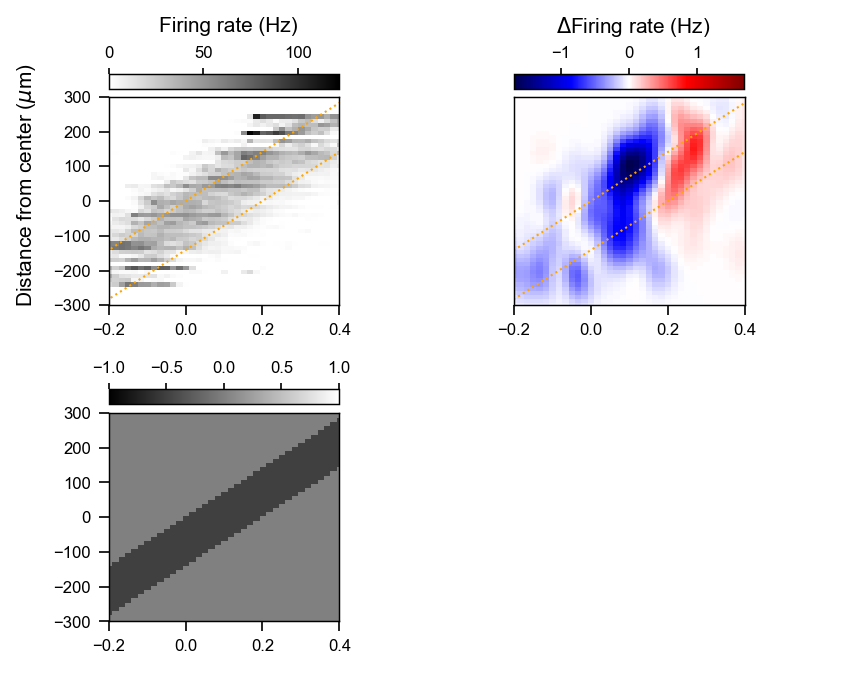

In [72]:
fig = plt.figure(figsize=(6, 5))
plt.text(-0.15, 0.87, 'Distance from center ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
plt.text(0.14, 1.15, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', fontsize=10)
plt.text(0.72, 1.15, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', fontsize=10)
plt.axis('off')
gs = fig.add_gridspec(5, 5, width_ratios=(3, 1, 1, 3, 1), height_ratios=(3, 1, 0.3, 3, 1), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, 
                      wspace=0.05, hspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(nn(mg_raw_st)[:, ::-1].T, cmap='gray_r', vmin=0, vmax=np.max(abs(nn(mg_raw_st))), aspect='auto', interpolation='nearest', extent=extent2)
ax1_cb = plt.axes([.1, 0.91, .256, .02])
cb1 = plt.colorbar(im1, cax=ax1_cb, orientation='horizontal')
ax1_cb.xaxis.set_ticks_position('top')
#ax1.imshow(bar_st[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax1.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17), color='orange', linestyle=':', linewidth=1)
ax1.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17)-24*(100/17), color='orange', linestyle=':', linewidth=1)
ax1.set_xlim((-0.2, 0.4))
ax1.set_ylim((-300, 300))
ax1.tick_params(size=5)
#ax1.set_xticks([])
#ax1.set_yticks([])

#ax2 = fig.add_subplot(gs[1, 0])

#ax3 = fig.add_subplot(gs[0, 1])

ax5 = fig.add_subplot(gs[0, 3])
im2 = ax5.imshow(m_smooth_st[:, ::-1].T, cmap='seismic', vmin=-np.max(abs(nn(m_smooth_st))), vmax=np.max(abs(nn(m_smooth_st))), aspect='auto', interpolation='nearest', extent=extent2)
ax5_cb = plt.axes([.55, 0.91, .256, .02])
cb2 = plt.colorbar(im2, cax=ax5_cb, orientation='horizontal')
ax5_cb.xaxis.set_ticks_position('top')
#ax5.imshow(bar_st[:, ::-1].T, cmap='gray', vmin=-1, vmax=0, aspect='auto', interpolation='nearest', alpha=0.3, extent=extent2)
ax5.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17), color='orange', linestyle=':', linewidth=1)
ax5.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)*60*2*(100/17)-24*(100/17), color='orange', linestyle=':', linewidth=1)
ax5.set_xlim((-0.2, 0.4))
ax5.set_ylim((-300, 300))
ax5.tick_params(size=5)
#ax5.set_xticks([])
ax5.set_yticks([])

ax9 = fig.add_subplot(gs[3, 0])
im3 = ax9.imshow(bar_st[:, ::-1].T, cmap='gray', vmin=-1, vmax=1, aspect='auto', interpolation='nearest', alpha=1, extent=extent2)
ax9_cb = plt.axes([.1, 0.49, .256, .02])
cb3 = plt.colorbar(im3, cax=ax9_cb, orientation='horizontal')
ax9_cb.xaxis.set_ticks_position('top')
ax9.set_xlim((-0.2, 0.4))
ax9.set_ylim((-300, 300))
ax9.tick_params(size=5)


#plt.savefig('fig_c01_1+delta+fr+spacetime', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_2+delta+fr+spacetime', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+stimulus+delta+fr', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+stimulus+delta+fr+2edges.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [40]:
N

1000

In [41]:
gain_a = np.linspace(1, 40, 8)
gain_d = np.linspace(-1, -40, 8)
con_sem = np.std(np.stack([np.nanmean(re['bs'][n]['gmtr']['c']['all']['con'], 0) for n in range(N)]), 0)
diff_sem = np.std(np.stack([smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s-1) for n in range(N)]), 0)
diff_sem_t = np.std(np.stack([smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t-1) for n in range(N)]), 0)

In [42]:
mg_s.max()

37.68179337645874

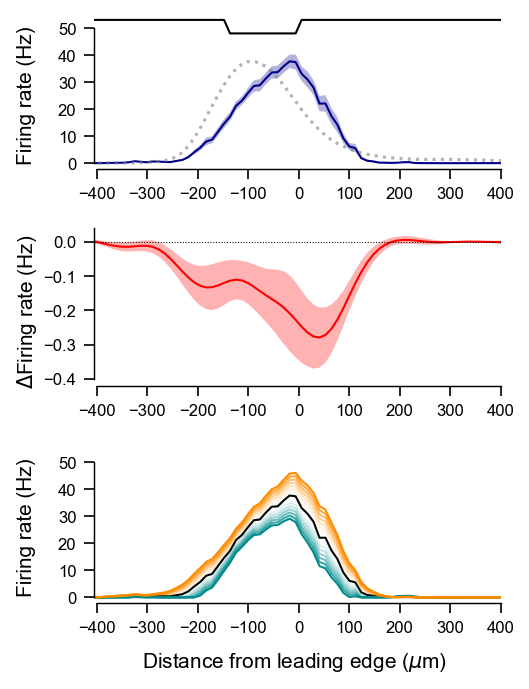

In [43]:
fig = plt.figure(figsize=(3.5, 4.5))

fig.text(0.53, 0, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', fontsize=10)
fig.text(0.02, 0.84, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.52, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.20, 'Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)

ax1 = plt.subplot(311)
ax1.plot(sbins, mg_s, 'darkblue', linewidth=1)
ax1.fill_between(sbins, mg_s-con_sem, mg_s+con_sem, color='darkblue', lw=0, alpha=0.3)
ax1.plot(sbins, np.nanmean(tr(bar_st), 0)*10 + 53, 'k', linewidth=1)
ax1.plot(sbins, np.nanmean(re['sample']['gmtr']['c']['ln']['con'], 0)/np.nanmean(re['sample']['gmtr']['c']['ln']['con'], 0).max()*mg_s.max(), color='gray', linewidth=1.5, linestyle=':', alpha=0.6)
ax1.set_xlim((-405, 400))
ax1.set_ylim((-2, 55))
ax1.tick_params(size=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_bounds(-400, 400)
ax1.spines['left'].set_bounds(0, 50)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=100))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=10))

ax2 = plt.subplot(312)
ax2.plot(sbins, m_s, 'r', linewidth=1)
ax2.fill_between(sbins, m_s-diff_sem, m_s+diff_sem, color='red', lw=0, alpha=0.3)
ax2.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax2.set_xlim((-405, 400))
ax2.set_ylim((-0.42, 0.03))
ax2.tick_params(size=5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_bounds(-400, 400)
ax2.spines['left'].set_bounds(-0.4, 0.04)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=100))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))

ax3 = plt.subplot(313)
ax3.plot(sbins, mg_s, 'k', linewidth=1)
for i, g in enumerate(gain_a):
    ax3.plot(sbins, np.clip(smooth_1d(mg_s + gain_a[i] * m_s, 0.5), 0, 100), 'darkcyan', linewidth=1, alpha=(abs(g)/np.max(abs(gain_a)))**1.7)
for i, g in enumerate(gain_d):
    ax3.plot(sbins, np.clip(smooth_1d(mg_s + gain_d[i] * m_s, 0.5), 0, 100), 'darkorange', linewidth=1, alpha=(abs(g)/np.max(abs(gain_d)))**1.7)
ax3.set_xlim((-405, 400))
ax3.set_ylim((-2, 55))
ax3.tick_params(size=5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_bounds(-400, 400)
ax3.spines['left'].set_bounds(0, 50)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(base=100))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=10))

plt.tight_layout()
#plt.savefig('fig_c01_all+delta+fr+space+model', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+delta+fr+space+model_2.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [44]:
v_mb_t = np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (1, 2, 3))
v_mb_t_sem = np.nanstd(v_mb_t, 0) / np.sqrt(v_mb_t.shape[0])
v_mb_t_lin = np.nanmean(ex.i_a['mb_lin_line_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (1, 2, 3))

v_mb_t_nostim = np.nanmean(ex.i_a['mb_baseline0_cen_i'][np.array(list(set(list(df.iloc[re['attrs']['g_list']]['exp_id'].unique())).intersection(list(df[df['mb_ns']==1]['exp_id'].unique()))))], (1, 2, 3))

v_mb_ns_t = smooth_1d(np.nanmean(re['sample']['gmtr']['c']['ns']['diff'], 1), sm_sigma_t-1)
v_mb_ns_t_sem = np.nanstd(np.stack([smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['ns']['diff'], 1), sm_sigma_t-1) for n in range(N)]), 0)

In [45]:
np.array(list(set(list(df.iloc[re['attrs']['g_list']]['exp_id'].unique())).intersection(list(df[df['mb_ns']==1]['exp_id'].unique()))))

array([4, 5, 7])

In [46]:
np.array(list(set(list(np.array(df[(df['exp_id'] == 4) + (df['exp_id'] == 5) + (df['exp_id'] == 7)].index))).intersection(list(np.array(df.iloc[re['attrs']['g_list']].index))))).shape

(25,)

In [47]:
df.iloc[re['attrs']['g_list']]['exp_id'].unique()

array([ 3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 16, 17])

In [48]:
np.array(df.iloc[re['attrs']['g_list']].index).shape

(94,)

In [49]:
print((tbins[np.argmin(m_t)])*1000, 
      (tbins[np.argmin(v_mb_ns_t)])*1000)

83.33333333333326 166.66666666666674


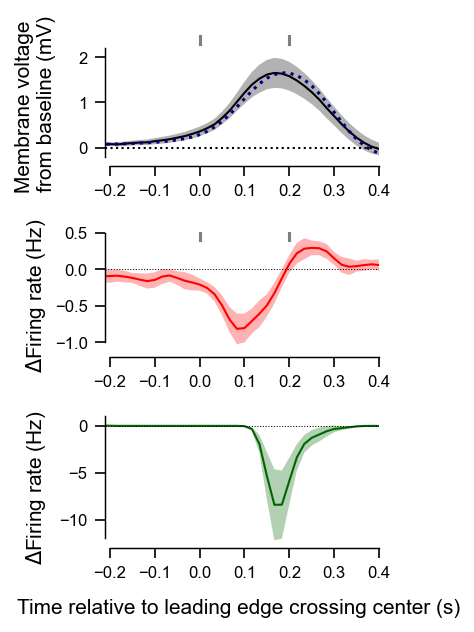

In [50]:
fig = plt.figure(figsize=(2.6, 4))

fig.text(0.54, 0, 'Time relative to leading edge crossing center (s)', verticalalignment='center', horizontalalignment='center', fontsize=10)
fig.text(0.02, 0.84, 'Membrane voltage \nfrom baseline (mV)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.52, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.20, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)

ax1 = plt.subplot(311)
ax1.plot([0, 0], [2.3, 2.5], 'k', linewidth=1.5, alpha=0.5)
ax1.plot([12 * (1/60), 12 * (1/60)], [2.3, 2.5], 'k', linewidth=1.5, alpha=0.5)
ax1.plot(tbins, np.nanmean(v_mb_t, 0), 'k', linewidth=1)
ax1.plot(tbins, np.nanmean(v_mb_t_lin, 0) / np.nanmean(v_mb_t_lin, 0).max() * np.nanmean(v_mb_t, 0).max(), 'darkblue', linestyle=':', linewidth=1.5)
ax1.fill_between(tbins, np.nanmean(v_mb_t, 0)-v_mb_t_sem, np.nanmean(v_mb_t, 0)+v_mb_t_sem, color='k', lw=0, alpha=0.3)
ax1.axhline(0, color='k', linestyle=':', linewidth=1)
ax1.set_xlim((-0.21, 0.4))
ax1.set_ylim((-0.4, 2.5))
ax1.tick_params(size=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_bounds(-0.2, 0.4)
ax1.spines['left'].set_bounds(-0.2, 2.2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=1))


ax2 = plt.subplot(312)
ax2.plot([0, 0], [0.4, 0.5], 'k', linewidth=1.5, alpha=0.5)
ax2.plot([12 * (1/60), 12 * (1/60)], [0.4, 0.5], 'k', linewidth=1.5, alpha=0.5)
ax2.plot(tbins, m_t, 'red', linewidth=1)
#ax2.plot(tbins, -np.roll(np.nanmean(v_mb_t, 0) / abs(np.nanmean(v_mb_t, 0).max()) * abs(m_t.min()), 1), 'darkblue', linestyle=':', linewidth=1.5)
ax2.fill_between(tbins, m_t-diff_sem_t, m_t+diff_sem_t, color='red', lw=0, alpha=0.3)
ax2.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax2.set_xlim((-0.21, 0.4))
ax2.set_ylim((-1.2, 0.6))
ax2.tick_params(size=5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_bounds(-0.2, 0.4)
ax2.spines['left'].set_bounds(-1, 0.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

ax3 = plt.subplot(313)
ax3.plot(tbins, v_mb_ns_t, 'darkgreen', linewidth=1)
#ax3.plot(tbins, -np.roll(np.nanmean(v_mb_t / abs(np.nanmean(v_mb_t, 0).max()) * abs(v_mb_ns_t.min()), 0), 1), 'darkblue', linestyle=':', linewidth=1.5)
ax3.fill_between(tbins, v_mb_ns_t-v_mb_ns_t_sem, v_mb_ns_t+v_mb_ns_t_sem, color='darkgreen', lw=0, alpha=0.3)
ax3.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax3.set_xlim((-0.21, 0.4))
ax3.set_ylim((-13, 1))
ax3.tick_params(size=5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_bounds(-0.2, 0.4)
ax3.spines['left'].set_bounds(-12, 1)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=5))

plt.tight_layout()
#plt.savefig('fig_c01_all+delta+fr+time+model', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+delta+fr+time+model_2.pdf', bbox_inches='tight',transparent=True, dpi=300)

In [51]:
v_mb_t_mean = np.nanmean(v_mb_t, 0)
v_mb_t_mean_buffer = np.concatenate((v_mb_t_mean, np.array([v_mb_t_mean[-1]]*29)))
v_mb_t_nostim_mean = np.nanmean(v_mb_t_nostim, 0)
v_mb_t_nostim_mean_buffer = np.concatenate((v_mb_t_nostim_mean, np.array([v_mb_t_nostim_mean[-1]]*29)))

In [52]:
import scipy.signal
exp_time = np.linspace(0, 0.5, 30)
exp_filter = np.exp(-exp_time / 0.017)[0:30]
recovered1, remainder1 = scipy.signal.deconvolve(v_mb_t_mean_buffer, exp_filter)
recovered2, remainder2 = scipy.signal.deconvolve(v_mb_t_nostim_mean_buffer, exp_filter)
current_chunk = recovered1 * np.sum(exp_filter)
current_chunk_nostim = recovered2 * np.sum(exp_filter)

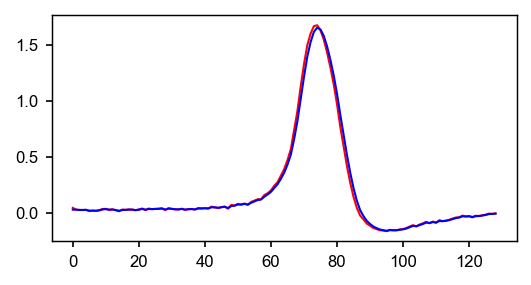

In [53]:
plt.plot(current_chunk, 'r')
plt.plot(v_mb_t_mean, 'b')

In [54]:
tr_list = [-4, -5, -7, -8, -10]
tr_filter = ex.g_a['tr_filter_rf_wn'][tr_list]
tr_filter_peak = np.linspace(-0.5, 0, 120)[np.argmin(tr_filter, 1)]
tr_filter_mean = np.mean(tr_filter, 0)
tr_filter_peak.mean()*1000, tr_filter_peak.std()/np.sqrt(len(tr_list))*1000

(-31.092436974789937, 1.916261218654017)

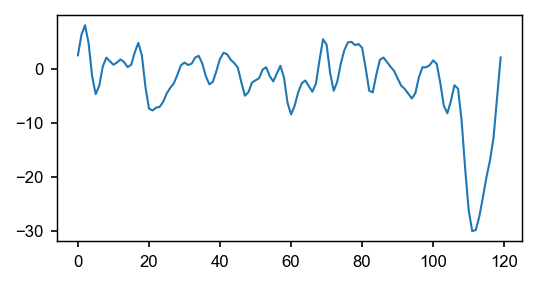

In [55]:
plt.plot(tr_filter_mean)

In [56]:
tr_lin_pred = ft.linear_response(tr_filter_mean[::-1], scipy.signal.resample(current_chunk, current_chunk.shape[0]*4))
tr_lin_pred_norm = tr_lin_pred/np.max(abs(tr_lin_pred))
tr_nostim_lin_pred = ft.linear_response(tr_filter_mean[::-1], scipy.signal.resample(current_chunk_nostim, current_chunk_nostim.shape[0]*4))
tr_nostim_lin_pred_norm = tr_nostim_lin_pred/np.max(abs(tr_nostim_lin_pred))

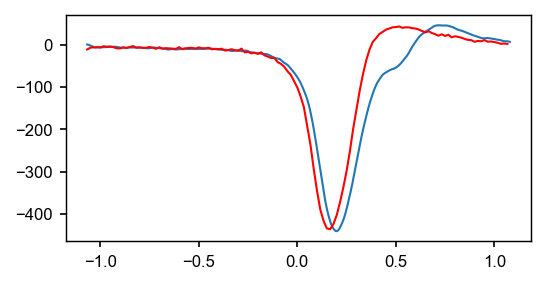

In [57]:
plt.plot(np.arange(0, 129*1/60, 1/240)-ex.tbins['mb_ad'][0][64], ft.linear_response(tr_filter_mean[::-1], scipy.signal.resample(current_chunk, current_chunk.shape[0]*4)))
plt.plot(np.arange(0, 129*1/60, 1/60)-ex.tbins['mb_ad'][0][64], -260*current_chunk, 'r')

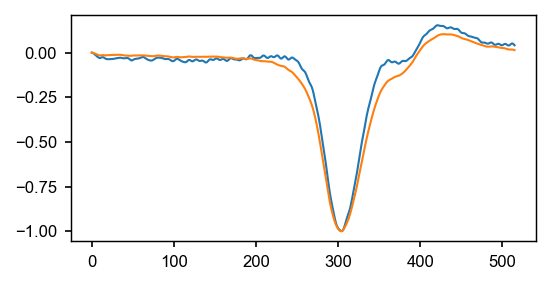

In [58]:
plt.plot(tr_nostim_lin_pred_norm)
plt.plot(tr_lin_pred_norm)

In [59]:
print((np.arange(0, 129*1/60, 1/240)[np.argmin(tr_lin_pred_norm)]-ex.tbins['mb_ad'][0][64])*1000,
      (np.arange(0, 129*1/60, 1/240)[np.argmin(tr_nostim_lin_pred_norm)]-ex.tbins['mb_ad'][0][64])*1000)

199.99999999999994 199.99999999999994


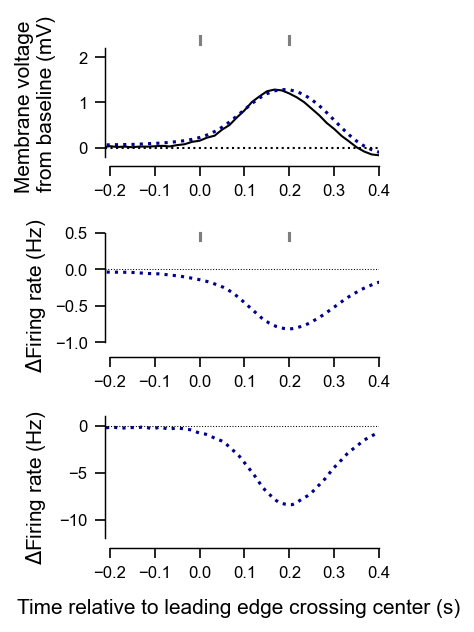

In [60]:
fig = plt.figure(figsize=(2.6, 4))

fig.text(0.54, 0, 'Time relative to leading edge crossing center (s)', verticalalignment='center', horizontalalignment='center', fontsize=10)
fig.text(0.02, 0.84, 'Membrane voltage \nfrom baseline (mV)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.52, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)
fig.text(0.02, 0.20, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center', rotation=90, fontsize=10)

ax1 = plt.subplot(311)
ax1.plot([0, 0], [2.3, 2.5], 'k', linewidth=1.5, alpha=0.5)
ax1.plot([12 * (1/60), 12 * (1/60)], [2.3, 2.5], 'k', linewidth=1.5, alpha=0.5)
ax1.plot(tbins, np.nanmean(v_mb_t_nostim, 0), 'k', linewidth=1)
ax1.plot(tbins, np.nanmean(v_mb_t_lin, 0) / np.nanmean(v_mb_t_lin, 0).max() * np.nanmean(v_mb_t_nostim, 0).max(), 'darkblue', linestyle=':', linewidth=1.5)
#ax1.plot(tbins, np.nanmean(v_mb_t_lin, 0) / np.nanmean(v_mb_t_lin, 0).max() * np.nanmean(v_mb_t, 0).max(), 'darkblue', linestyle=':', linewidth=1.5)
#ax1.fill_between(tbins, np.nanmean(v_mb_t, 0)-v_mb_t_sem, np.nanmean(v_mb_t, 0)+v_mb_t_sem, color='k', lw=0, alpha=0.3)
ax1.axhline(0, color='k', linestyle=':', linewidth=1)
ax1.set_xlim((-0.21, 0.4))
ax1.set_ylim((-0.4, 2.5))
ax1.tick_params(size=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_bounds(-0.2, 0.4)
ax1.spines['left'].set_bounds(-0.2, 2.2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=1))


ax2 = plt.subplot(312)
ax2.plot([0, 0], [0.4, 0.5], 'k', linewidth=1.5, alpha=0.5)
ax2.plot([12 * (1/60), 12 * (1/60)], [0.4, 0.5], 'k', linewidth=1.5, alpha=0.5)
#ax2.plot(tbins, m_t, 'red', linewidth=1)
ax2.plot(np.arange(0, 129*1/60, 1/240)-ex.tbins['mb_ad'][0][64], tr_lin_pred_norm * np.max(abs(m_t)), 'darkblue', linestyle=':', linewidth=1.5)
#ax2.fill_between(tbins, m_t-diff_sem_t, m_t+diff_sem_t, color='red', lw=0, alpha=0.3)
ax2.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax2.set_xlim((-0.21, 0.4))
ax2.set_ylim((-1.2, 0.6))
ax2.tick_params(size=5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_bounds(-0.2, 0.4)
ax2.spines['left'].set_bounds(-1, 0.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

ax3 = plt.subplot(313)
#ax3.plot(tbins, v_mb_ns_t, 'darkgreen', linewidth=1)
ax3.plot(np.arange(0, 129*1/60, 1/240)-ex.tbins['mb_ad'][0][64], tr_nostim_lin_pred_norm * np.max(abs(v_mb_ns_t)), 'darkblue', linestyle=':', linewidth=1.5)
#ax3.fill_between(tbins, v_mb_ns_t-v_mb_ns_t_sem, v_mb_ns_t+v_mb_ns_t_sem, color='darkgreen', lw=0, alpha=0.3)
ax3.axhline(0, color='k', linestyle=':', linewidth=0.5)
ax3.set_xlim((-0.21, 0.4))
ax3.set_ylim((-13, 1))
ax3.tick_params(size=5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_bounds(-0.2, 0.4)
ax3.spines['left'].set_bounds(-12, 1)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(base=5))

plt.tight_layout()
#plt.savefig('fig_c01_all+delta+fr+time+model', bbox_inches='tight', dpi=300)
#plt.savefig('fig_c01_all+delta+fr+time+model_4_nostim+linmodel.pdf', bbox_inches='tight',transparent=True, dpi=300)

In [85]:
print(scipy.stats.pearsonr(scipy.signal.resample(tr_nostim_lin_pred_norm, 129)[52:-41], v_mb_ns_t[52:-41]),  # -0.2 : 0.4 s
      scipy.stats.pearsonr(scipy.signal.resample(tr_lin_pred_norm, 129)[52:-41], m_t[52:-41]))

(0.7556878797614976, 9.923850066741085e-08) (-0.1291322076394652, 0.4528930913732651)


In [48]:
i_peak_delta_t = (np.argmax(v_mb_t_lin, 1) - np.argmax(v_mb_t, 1)) * (1/60)
i_peak_delta_t_sem = np.std(i_peak_delta_t)/np.sqrt(i_peak_delta_t.shape[0])
print('peak shift in time of linear model from intracellular recording')
print((1000*i_peak_delta_t.mean(), 1000*i_peak_delta_t_sem)) # [ms]

peak shift in time of linear model from intracellular recording
(13.88888888888889, 3.8456591957954056)


In [49]:
print('peak shift of ganglion cell firing rate change from expected linear transmission')
print(((np.argmin(m_t) - np.argmin(v_mb_ns_t)) * (1/60)) * 1000) # [ms]
print(np.std(np.argmin(np.stack([smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 1), sm_sigma_t) for n in range(N)]), 1) - np.argmin(np.stack([smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['ns']['diff'], 1), sm_sigma_t) for n in range(N)]), 1)) * (1/60) * 1000) # sem

peak shift of ganglion cell firing rate change from expected linear transmission
-83.33333333333333
15.035430378498203


In [50]:
# from linear transmission to the actual transmission
(np.argmin(m_t) - np.argmax(np.roll(np.nanmean(v_mb_t, 0) / abs(np.nanmean(v_mb_t, 0).max()) * abs(m_t.min()), 1))) * 1/60 * 1000

-100.0

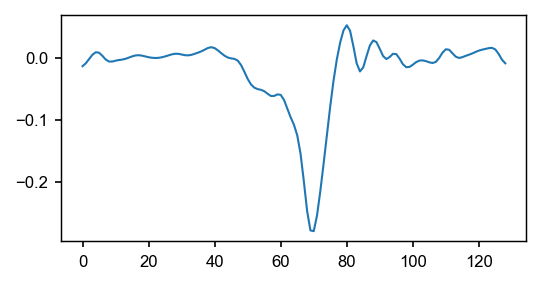

In [33]:
plt.plot(np.nanmean(re['bs'][80]['gmtr']['c']['all']['diff_sm'], 1))

In [ ]:
tr_list = [-4, -5, -7, -8, -10]
tr_filter = ex.g_a['tr_filter_rf_wn'][tr_list]
tr_filter_peak = np.nanmean(np.linspace(-0.5, 0, 120)[np.argmin(tr_filter, 1)])
tr_filter_peak.mean() * 1000

-31.092436974789937

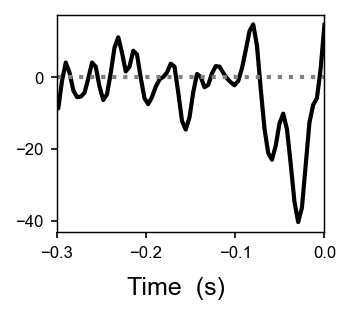

In [52]:
fig = plt.figure(figsize=(2.5, 2))

fig.text(0.5, 0, 'Time  (s)', verticalalignment='center', horizontalalignment='center')

ax = plt.subplot(111)
ax.plot(np.linspace(-0.5, 0, 120), tr_filter[1], 'k', linewidth=2)
ax.set_xlim(-0.3, 0)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
plt.tight_layout()

#plt.savefig('fig_c01_tr_filter', bbox_inches='tight', dpi=300)

In [207]:
pred_line = ft.linear_response(ex.rf['i']['line'][10][::-1, :], ex.stim['line'][10])
pred_line_ext = pred_line[4500:5100]
pred_line_ext -= pred_line_ext.mean()
pred_line_ext /= pred_line_ext.std()

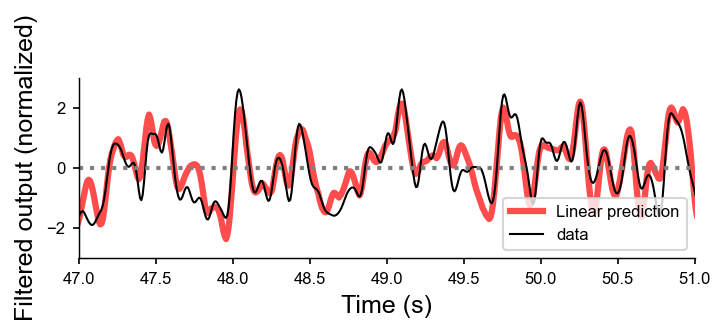

In [264]:
fig = plt.figure(figsize=(5, 2))
ax = plt.subplot(111)
ax.plot(ex.tbins['line'][10][4500:5100], pred_line[4500:5100], color='red', linewidth=3, alpha=0.7, label='Linear prediction')
ax.plot(ex.tbins['line'][10][4500:5100], ex.i['line'][10][4500:5100], 'k', linewidth=1, label='data')
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlim([47, 51])
ax.set_ylim([-3, 3])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Filtered output (normalized)')
ax.legend(fontsize=8)
plt.tight_layout()
#plt.savefig('fig_supp_ex10_intracell_linearity.png', bbox_inches='tight', dpi=300)

In [20]:
z = np.stack([np.nanmean(ex.g_a['mb_ad_cen_i'][g][0], 1) for g in np.array(df[df['exp_id'] == 7].index)]) / ex.tbins['mb_ad'][0][1]

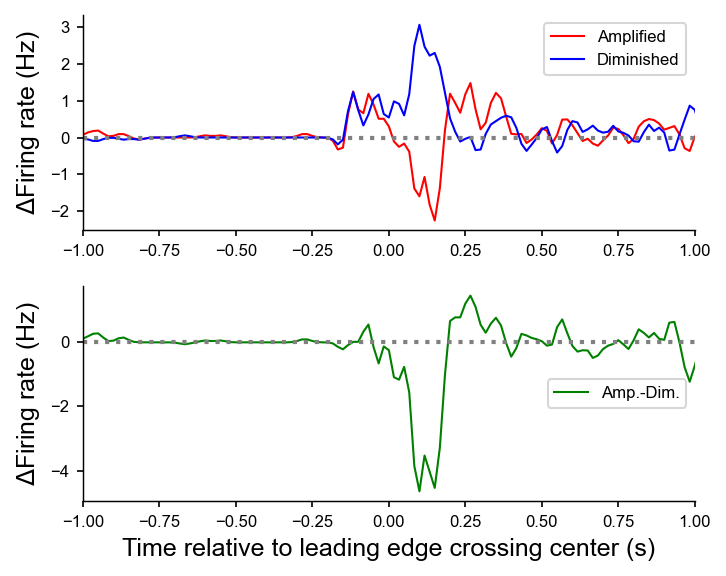

In [21]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(211)
ax.plot(tbins, smooth_1d(np.nanmean(z[:, 1, :] - z[:, 0, :], 0), 1), 'r', label='Amplified')
ax.plot(tbins, smooth_1d(np.nanmean(z[:, 2, :] - z[:, 0, :], 0), 1), 'b', label='Diminished')
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlim([-1, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta$Firing rate (Hz)')
ax.legend(fontsize=8)
ax = plt.subplot(212)
ax.plot(tbins, smooth_1d(np.nanmean(z[:, 1, :] - z[:, 2, :], 0), 1), 'g', label='Amp.-Dim.')
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlim([-1, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time relative to leading edge crossing center (s)')
ax.set_ylabel('$\Delta$Firing rate (Hz)')
ax.legend(loc='right', fontsize=8)
plt.tight_layout()
#plt.savefig('fig_supp_ex7_delta+fr+time.png', bbox_inches='tight', dpi=300)

In [23]:
z.shape

(13, 3, 129)

In [ ]:
### 

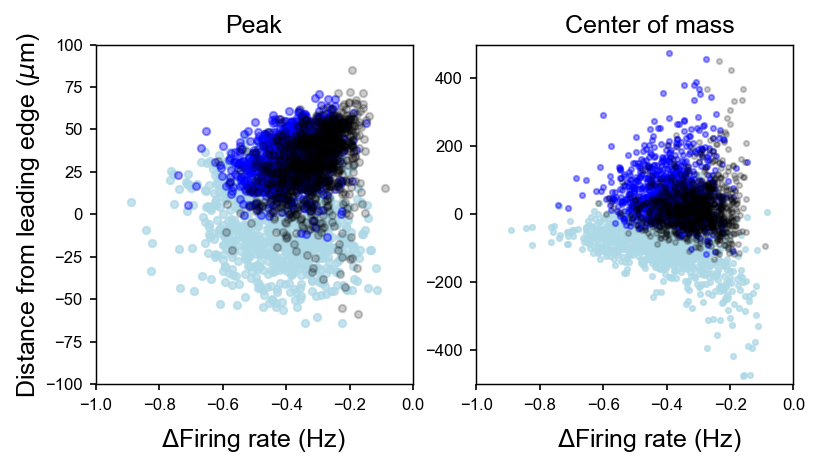

In [124]:
fig = plt.figure(figsize=(6, 3))

fig.text(0.30, 0.92, 'Peak', verticalalignment='center', horizontalalignment='center')
fig.text(0.74, 0.92, 'Center of mass', verticalalignment='center', horizontalalignment='center')
fig.text(0.30, 0, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center')
fig.text(0.74, 0, '$\Delta$Firing rate (Hz)', verticalalignment='center', horizontalalignment='center')
fig.text(0.05, 0.50, 'Distance from leading edge ($\mu$m)', verticalalignment='center', horizontalalignment='center', rotation=90)

ax = plt.subplot(121)
ax.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s))) for n in range(N)]) 
        + np.random.normal(0, 4, N), color='lightblue', marker='.', linestyle='', markersize=7, alpha=0.7)
ax.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s))) for n in range(N)]) 
        + np.random.normal(0, 4, N), color='blue', marker='.', linestyle='', markersize=7, alpha=0.4)
ax.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(np.argmin(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))) for n in range(N)]) 
        + np.random.normal(0, 4, N), 'k.', markersize=7, alpha=0.2)
ax.set_xlim((-1, 0))
ax.set_ylim((-100, 100))

ax2 = plt.subplot(122)
ax2.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['1']['diff'], 0), sm_sigma_s))[0]) for n in range(N)]) 
        + np.random.normal(0, 4, N), color='lightblue', marker='.', linestyle='', markersize=5, alpha=0.7)
ax2.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['2']['diff'], 0), sm_sigma_s))[0]) for n in range(N)]) 
        + np.random.normal(0, 4, N), color='blue', marker='.', linestyle='', markersize=5, alpha=0.4)
ax2.plot(np.stack([np.min(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s)) for n in range(N)]),
        np.stack([i2s(scipy.ndimage.center_of_mass(smooth_1d(np.nanmean(re['bs'][n]['gmtr']['c']['all']['diff'], 0), sm_sigma_s))[0]) for n in range(N)]) 
        + np.random.normal(0, 4, N), 'k.', markersize=5, alpha=0.2)
ax2.set_xlim((-1, 0))
ax2.set_ylim((-500, 500))

#plt.savefig('fig_c01_delta+fr+sausage+plot', bbox_inches='tight', dpi=300)

In [ ]:
####################33

In [ ]:
scipy.stats.pearsonr(i2s(com_con_all_s), i2s(com_diff_all_s) - i2s(com_con_all_s))

In [ ]:
plt.plot(i2s(com_con_all_s), i2s(com_diff_all_s) - i2s(com_con_all_s), 'k.')

In [24]:
cc_mb_i_re_lin = np.zeros((12, 2))
cc_mb_i_rl_rr = np.zeros((12,))
mb_i_re = np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (2, 3))
mb_i_lin = np.nanmean(ex.i_a['mb_lin_line_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (2, 3))
for i in range(cc_mb_i_re_lin.shape[0]):
    for lr in range(cc_mb_i_re_lin.shape[1]):
        cc_mb_i_re_lin[i, lr] = scipy.stats.pearsonr(mb_i_re[i, lr, :], mb_i_lin[i, lr, :])[0]
for i in range(cc_mb_i_re_lin.shape[0]):
    cc_mb_i_rl_rr[i] = scipy.stats.pearsonr(mb_i_re[i, 0, :], mb_i_lin[i, 1, :])[0]

In [25]:
np.nanmean(cc_mb_i_re_lin), np.nanmean(cc_mb_i_rl_rr)

(0.9277229571505337, 0.9305270378531789)

(0.0, 1.0)

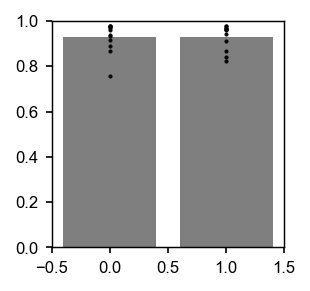

In [26]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.bar([0], np.nanmean(cc_mb_i_re_lin), color='k', alpha=0.5)
ax.plot(np.zeros(12) + np.random.normal(0, 0.0, 12), np.mean(cc_mb_i_re_lin, 1), 'k.', alpha=0.9)
ax.bar([1], np.nanmean(cc_mb_i_rl_rr), color='k', alpha=0.5)
ax.plot(np.ones(12) + np.random.normal(0, 0.0, 12), cc_mb_i_rl_rr, 'k.', alpha=0.9)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, 1)
#plt.savefig('fig_c01_i_linearity', bbox_inches='tight', dpi=300)

In [27]:
df.iloc[re['attrs']['g_list']]['exp_id'].unique()

array([ 3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 16, 17])

In [43]:
s1_soa = np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3))
s2_soa = smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t-0.5)
s1_soa -= s1_soa.mean()
s2_soa -= s2_soa.mean()
s1_diff = np.diff(s1_soa)
s1_diff -= s1_diff.mean()
xcorr_soa = np.correlate(s2_soa/s2_soa.std(), s1_soa/s1_soa.std(), 'full')
xcorr_soa_diff = np.correlate(s2_soa[1:]/s2_soa[1:].std(), s1_diff/s1_diff.std(), 'full')
#xcorr_soa_norm = xcorr_soa / np.max(abs(xcorr_soa))
#xcorr_soa_diff_norm = xcorr_soa_diff / np.max(abs(xcorr_soa_diff))
lags = np.arange(-len(s2_soa)+1, len(s1_soa)) / 60
lags_diff = np.arange(-len(np.diff(s2_soa))+1, len(s1_soa[1:])) / 60

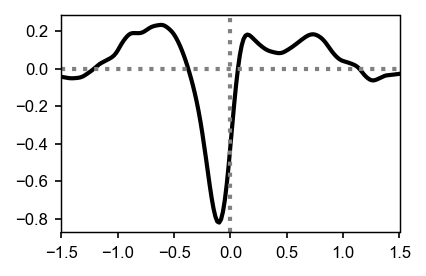

In [44]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)
ax.plot(lags, xcorr_soa/129, 'k', linewidth=2)
ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-10, 5)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
plt.tight_layout()

In [45]:
lags[np.argmax(abs(xcorr_soa_norm))]

-0.1

In [46]:
scipy.stats.pearsonr(s1_soa, s2_soa)[0], scipy.stats.pearsonr(np.diff(s1_soa), s2_soa[1:])[0]

(-0.40923866100306544, -0.8268456283329635)

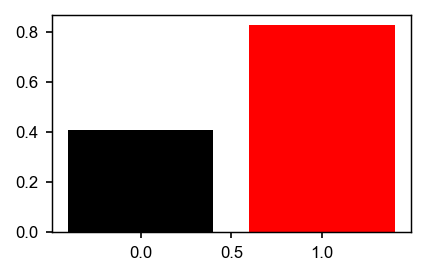

In [47]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)
ax.bar([0], [-scipy.stats.pearsonr(s1_soa, s2_soa)[0]], color='black')
ax.bar([1], [-scipy.stats.pearsonr(np.diff(s1_soa), s2_soa[1:])[0]], color='red')
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-10, 5)
plt.tight_layout()

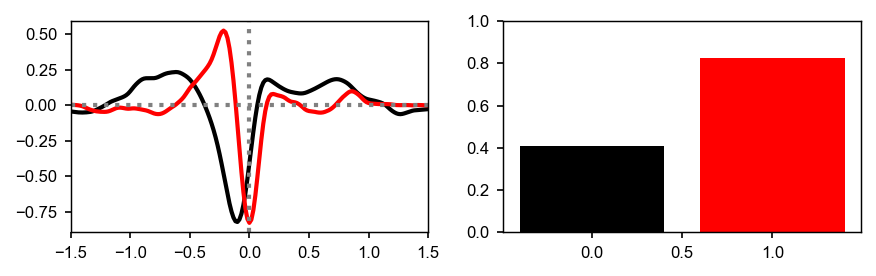

In [48]:
fig = plt.figure(figsize=(6, 2))
ax = plt.subplot(121)
ax.plot(lags, xcorr_soa/129, 'k', linewidth=2)
ax.plot(lags_diff, xcorr_soa_diff/128, 'r', linewidth=2)
ax.set_xlim(-1.5, 1.5)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
ax = plt.subplot(122)
ax.bar([0], [-scipy.stats.pearsonr(s1_soa, s2_soa)[0]], color='black')
ax.bar([1], [-scipy.stats.pearsonr(np.diff(s1_soa), s2_soa[1:])[0]], color='red')
ax.set_ylim(0, 1)
plt.tight_layout()
#plt.savefig('fig_c01_xcorr+pearsonr', bbox_inches='tight', dpi=300)

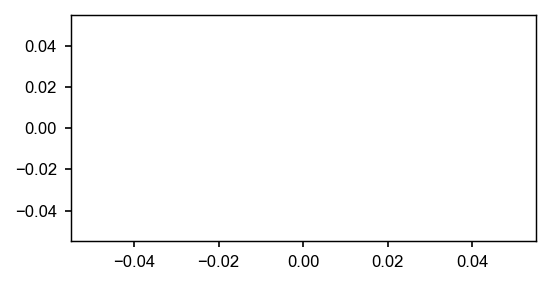

In [62]:
plt.plot(np.correlate([0, 1, 0, 0], [0, 0, 1, 0]))

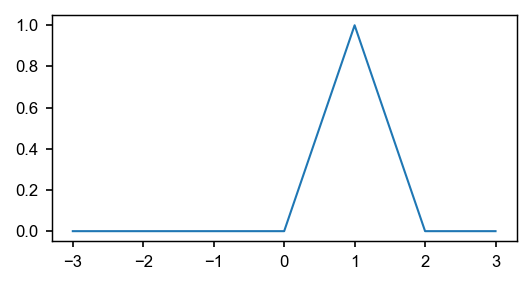

In [60]:
plt.plot(np.arange(-3, 4), np.correlate([0, 0, 1, 0], [0, 1, 0, 0], 'full'))

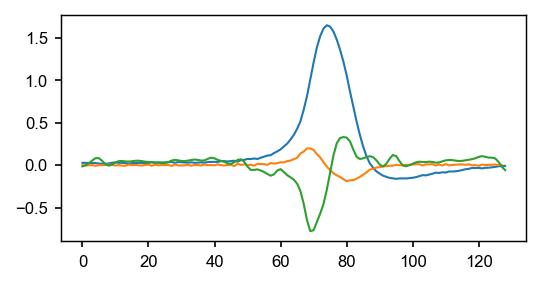

In [42]:
s1_soa = np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (0, 1, 2, 3))
plt.plot(s1_soa)
plt.plot(np.diff(s1_soa))
plt.plot(s2_soa)

In [63]:
class_num=8
with open(proj_dir + 'data-figure/' + 'bootstrap_c' + "{:02d}".format(class_num) + '.p', 'rb') as f3:
    re = pickle.load(f3)
with open(proj_dir + 'data-figure/' + 'ex_210214.p', 'rb') as f:
    ex = pickle.load(f)  
with open(proj_dir + 'data-figure/' + 'df_210214.p', 'rb') as f2:
    df = pickle.load(f2)

In [64]:
df.iloc[re['attrs']['g_list']]['exp_id'].unique()

array([ 0, 15])

In [65]:
s1_nsoa = np.nanmean(ex.i_a['mb_baseline0_cen_i'][[0, 15]], (0, 1, 2, 3))
s2_nsoa = smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 1), sm_sigma_t-0.5)
xcorr_nsoa = np.correlate(s2_nsoa/s2_nsoa.std(), s1_nsoa/s1_nsoa.std(), 'full')
xcorr_nsoa_norm = xcorr_nsoa / np.max(abs(xcorr_nsoa))

In [66]:
s1_c0 = np.nanmean(ex.i_a['mb_baseline0_cen_i'][0], (0, 1, 2))
s1_c15 = np.nanmean(ex.i_a['mb_baseline0_cen_i'][15], (0, 1, 2))
s2_c0_raw = ((np.nanmean(np.stack([ex.g_a['mb_ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[1] - 
              np.nanmean(np.stack([ex.g_a['mb_ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[2]) + 
             (np.nanmean(np.stack([ex.g_a['mb_da_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[1] - 
              np.nanmean(np.stack([ex.g_a['mb_da_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[2]) +
             (np.nanmean(np.stack([ex.g_a['mb_2ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[1] - 
              np.nanmean(np.stack([ex.g_a['mb_2ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[2]) +
             (np.nanmean(np.stack([ex.g_a['mb_2da_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[1] - 
              np.nanmean(np.stack([ex.g_a['mb_2da_cen_i'][g] for g in np.array(df[df['exp_id'] == 0].index)]), (0, 1, 3))[2]))*60/4
s2_c15_raw = ((np.nanmean(np.stack([ex.g_a['mb_2ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 15].index)]), (0, 1, 3))[1] - 
               np.nanmean(np.stack([ex.g_a['mb_2ad_cen_i'][g] for g in np.array(df[df['exp_id'] == 15].index)]), (0, 1, 3))[2]) + 
              (np.nanmean(np.stack([ex.g_a['mb_2da_cen_i'][g] for g in np.array(df[df['exp_id'] == 15].index)]), (0, 1, 3))[1] - 
               np.nanmean(np.stack([ex.g_a['mb_2da_cen_i'][g] for g in np.array(df[df['exp_id'] == 15].index)]), (0, 1, 3))[2]))*60/2
s2_c0 = smooth_1d(s2_c0_raw, sm_sigma_t-0.5)
s2_c15 = smooth_1d(s2_c15_raw, sm_sigma_t-0.5)
xcorr_c0 = np.correlate(s2_c0/s2_c0.std(), s1_c0/s1_c0.std(), 'full')
xcorr_c15 = np.correlate(s2_c15/s2_c15.std(), s1_c15/s1_c15.std(), 'full')
xcorr_c0_norm = xcorr_c0 / np.max(abs(xcorr_c0))
xcorr_c15_norm = xcorr_c15 / np.max(abs(xcorr_c15))

In [1]:
scipy.stats.pearsonr(s1_c15, s2_c15)

NameError: name 'scipy' is not defined

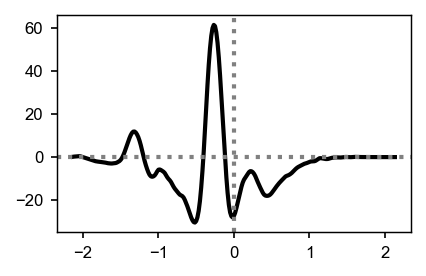

In [67]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)
ax.plot(lags, xcorr_nsoa, 'k', linewidth=2)
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-10, 5)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
plt.tight_layout()

In [68]:
lags[np.argmax(abs(xcorr_nsoa_norm))]

-0.26666666666666666

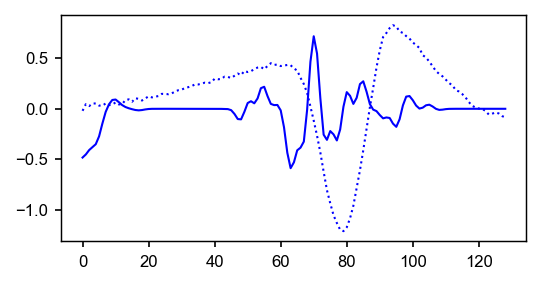

In [79]:
#plt.plot(s1_c0, 'r:')
#plt.plot(s2_c0, 'r')
plt.plot(s1_c15, 'b:')
plt.plot(s2_c15, 'b')

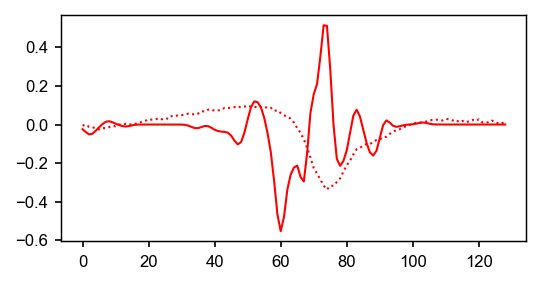

In [80]:
plt.plot(s1_c0, 'r:')
plt.plot(s2_c0, 'r')

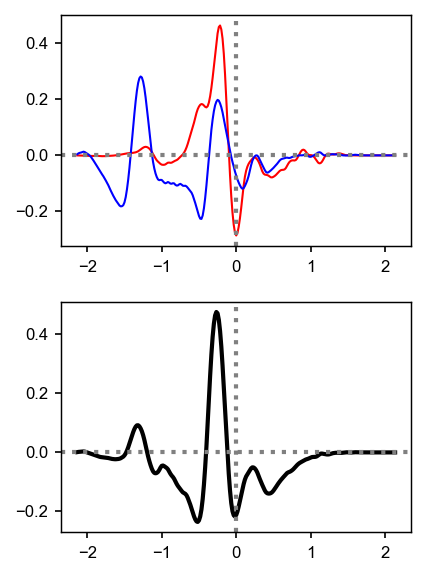

In [69]:
fig = plt.figure(figsize=(3, 4))
ax = plt.subplot(211)
ax.plot(lags, xcorr_c0/129, 'r', linewidth=1)
ax.plot(lags, xcorr_c15/129, 'b', linewidth=1)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
ax = plt.subplot(212)
ax.plot(lags, xcorr_nsoa/129, 'k', linewidth=2)
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-10, 5)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
plt.tight_layout()

In [70]:
scipy.stats.pearsonr(smooth_1d(s2_c0, 3), smooth_1d(s2_c15, 3))

(0.3972611090986904, 3.1405956456047873e-06)

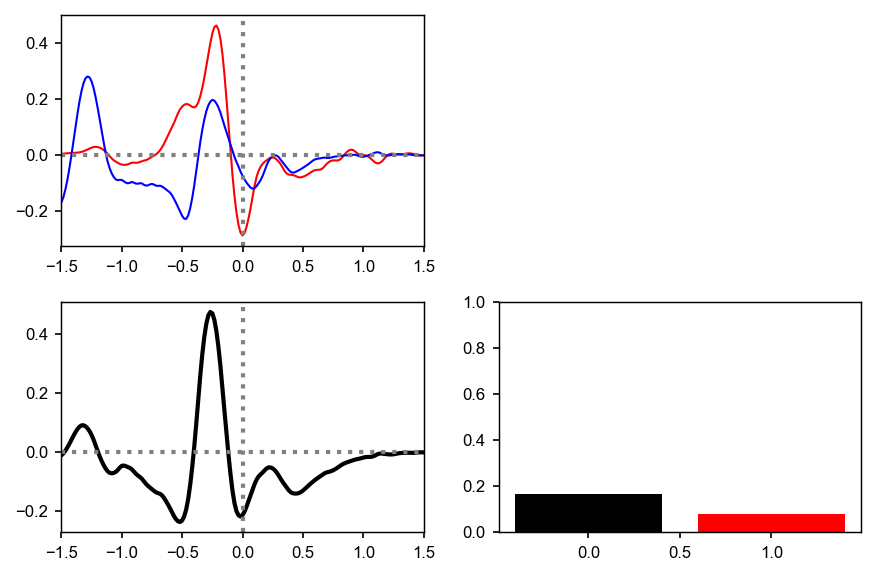

In [71]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(221)
ax.plot(lags, xcorr_c0/129, 'r', linewidth=1)
ax.plot(lags, xcorr_c15/129, 'b', linewidth=1)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlim(-1.5, 1.5)

ax = plt.subplot(223)
ax.plot(lags, xcorr_nsoa/129, 'k', linewidth=2)
ax.set_xlim(-1.5, 1.5)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.axvline(0, color='gray', linestyle=':', linewidth=2)

ax = plt.subplot(224)
ax.bar([0], [-scipy.stats.pearsonr(s1_nsoa, s2_nsoa)[0]], color='black')
ax.bar([1], [-scipy.stats.pearsonr(np.diff(s1_nsoa), s2_nsoa[1:])[0]], color='red')
ax.set_ylim(0, 1)
plt.tight_layout()
#plt.savefig('fig_c08_xcorr+pearsonr', bbox_inches='tight', dpi=300)

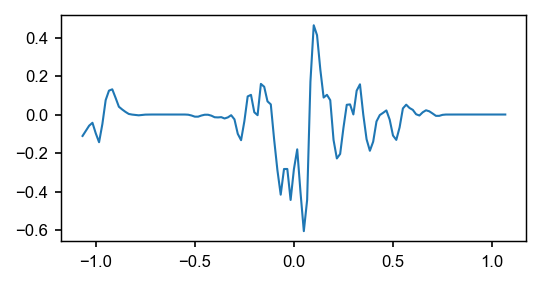

In [18]:
plt.plot(tbins, smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 1), 1))

In [255]:
scipy.stats.pearsonr(s1_nsoa, s2_nsoa)[0], scipy.stats.pearsonr(np.diff(s1_nsoa), s2_nsoa[1:])[0]

(-0.16474238135929292, -0.08134986528123914)

In [19]:
v_mb_t = np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (1, 2, 3))

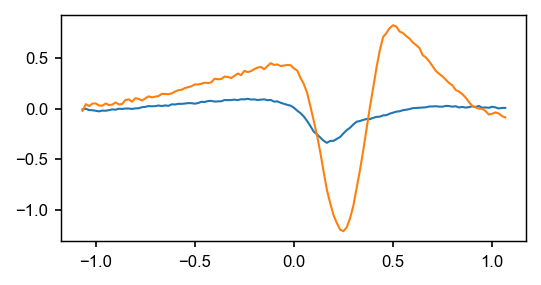

In [25]:
plt.plot(tbins, v_mb_t.T)

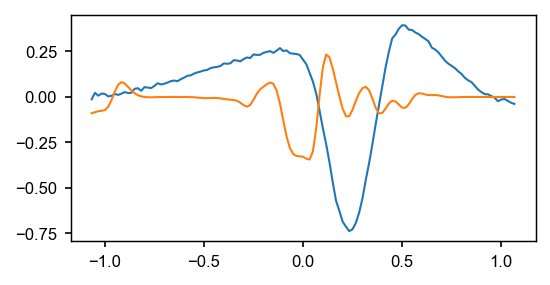

In [20]:
plt.plot(tbins, v_mb_t.mean(0))
plt.plot(tbins, smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 1), 2))
plt.savefig('fig_non-SOA.pdf', bbox_inches='tight', transparent=True, dpi=300)

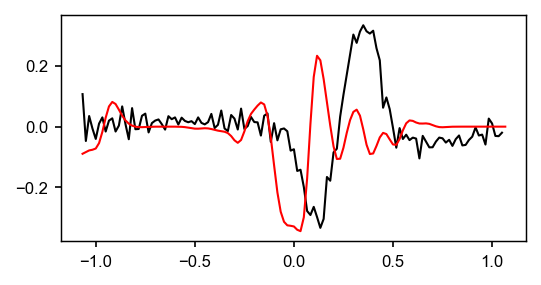

In [24]:
#plt.plot(tbins[:-1], v_mb_t.mean(0)[:-1])
plt.plot(tbins[:-1], np.diff(v_mb_t.mean(0))*3, 'k')
plt.plot(tbins, smooth_1d(np.nanmean(re['sample']['gmtr']['c']['all']['diff'], 1), 2), 'r')


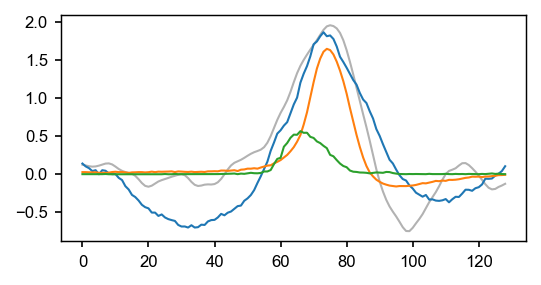

In [39]:
plt.plot(np.nanmean(ex.i_a['mb_lin_line_baseline0_cen_i'][9], (0, 1, 2)), 'k', alpha=0.3)
plt.plot(np.nanmean(ex.i_a['mb_baseline0_cen_i'][9], (0, 1, 2)))
plt.plot(np.nanmean(np.nanmean(ex.i_a['mb_baseline0_cen_i'][df.iloc[re['attrs']['g_list']]['exp_id'].unique()], (1, 2, 3)), 0))
#plt.plot(np.nanmean(ex.g_a['mb_2ad_cen_g'][0][0, 0, :, :], 0))
#plt.plot(np.nanmean(ex.g_a['mb_2da_cen_g'][0][0, 0, :, :], 0))
plt.plot(np.nanmean(np.stack([np.nanmean(ex.g_a['mb_ad_cen_g'][g][0, 0, :, :], 0) for g in range(60)]), 0))
#plt.plot(np.nanmean(np.stack([np.nanmean(ex.g_a['mb_da_cen_g'][g][0, 0, :, :], 0) for g in range(60)]), 0))